# Downstream Analysis using edgeR normlised counts
## Xiaonan Wang
## 23Oct2021

In [29]:
#%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
from os import listdir
from os.path import isfile, join
import re
import anndata
import seaborn as sns
import smqpp

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
print(smqpp.__version__)

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.set_figure_params(dpi=80, color_map='viridis', vector_friendly=False,  dpi_save=300)

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.20.3 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.1 statsmodels==0.13.1 python-igraph==0.9.8 louvain==0.7.1 pynndescent==0.5.5
0.1.2


# Differential expression analysis

In [60]:
adata_raw = sc.read('./write/patel_smq2_LSK_raw.h5ad')
adata = sc.read('./write/patel_smq2_LSK_processed_regressout_cellcycle.h5ad')

In [61]:
cnt = adata_raw.X.T
meta = adata.obs
GN = adata_raw.var_names

In [30]:
%reload_ext rpy2.ipython

In [4]:
%%R
suppressMessages(library(edgeR))
suppressMessages(library(scran))
source("/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Lab_Members/Niki/Files/DESeq_source_v1.R")

In [62]:
%%R -i cnt -i meta -i GN
colnames(cnt) = rownames(meta)
rownames(cnt) = GN
meta$ID = rownames(meta)

### DE for each cell type
Pair-wise comparisons between KO genotype vs WT for each cell type.

In [63]:
%%R
#ct = unique(meta$Combined_CT)
ct = c("LTHSC", "STHSC", "MPP", "LMPP", "MEP", "GMP")
con = c("Aldh2KO", "Fancd2KO", "p53KO", "DKO", "TKO")
# ct = "LTHSC"
# con = "DKO"
dir = './DEres/pw_new'
lapply(ct, function(x){
    print(x)
    idx = meta$Combined_CT == x
    cnt_sub = cnt[,idx]
    meta_sub = meta[idx,]
    #print(colnames(meta_sub))
    Condition = factor(meta_sub$Condition, levels=c("WT", "Aldh2KO", "Fancd2KO", "p53KO", "DKO", "TKO"))
    #Phase = meta_sub$phase
    #Batch = as.factor(as.character(meta_sub$Genotype))
    design = model.matrix(~Condition)
    #print(dim(design))
    obj = DGEList(counts=cnt_sub, group=Condition)
    keep = filterByExpr(obj, group=Condition,min.count=1, min.total.count=1, large.n=10, min.prop=0.3)
    print(sum(keep))
    obj = obj[keep, ,keep.lib.sizes=FALSE]
    obj = calcNormFactors(obj)
    #sf = calculateSumFactors(cnt_sub[keep,], clusters=Condition)
    #obj$samples$norm.factors = sf
    obj = estimateDisp(obj, design, robust=TRUE)
    saveRDS(obj, file=paste0("obj_", x, ".rds"))
    fit = glmQLFit(obj, design, robust=TRUE)
    print(colnames(design))
    lapply(con, function(y){
        print(y)       
        if ((sum(Condition==y) > 3) & (sum(Condition == "WT") > 3)){
            qlf = glmQLFTest(fit, coef=match(y,c("WT", "Aldh2KO", "Fancd2KO", "p53KO", "DKO", "TKO")))
            DEres = as.data.frame(topTags(qlf, n=nrow(cnt_sub)))
            print(head(DEres))
            #print(DEres[match(c("Satb1", "Vwf", "Slamf1", "Mpo", "Bcl11a", "Sox4"), rownames(DEres)),])

            upG = rownames(DEres)[(DEres$FDR < 0.1) & (DEres$logFC > 0)]
            downG = rownames(DEres)[(DEres$FDR < 0.1) & (DEres$logFC < 0)]
            prefix = paste(dir, "DEres_", x, "_", y,"vsWT", sep="")
            write.table(DEres, paste(prefix, "_DEtable.txt", sep=""), quote=F, row.names=T, col.names=T, sep="\t")
            write.table(upG, paste(prefix, "_upG.txt", sep=""), quote=F, row.names=F, col.names=F, sep="\t")
            write.table(downG, paste(prefix, "_downG.txt", sep=""), quote=F, row.names=F, col.names=F, sep="\t")
            print(length(upG))
            print(length(downG))
        }
    })
})

[1] "LTHSC"
[1] 13435
[[1]]
NULL



Perform further DE analysis between DKO vs TKO for each cell type.

In [73]:
%%R
ct = c("LTHSC", "STHSC", "MPP", "LMPP", "MEP", "GMP")
dir = './DEres/pw_new/'
lapply(ct, function(x){
    print(x)
    obj = readRDS(paste0("obj_", x, ".rds"))
    fit = glmQLFit(obj, obj$design, robust=TRUE)
    print(colnames(fit))
    if ((sum(fit$design[,"ConditionDKO"]) > 3) & (sum(fit$design[,"ConditionTKO"]) > 3)){
            qlf = glmQLFTest(fit, contrast=c(0, 0, 0, 0, 1, -1))
            DEres = as.data.frame(topTags(qlf, n=nrow(obj$count)))
            print(head(DEres))
            upG = rownames(DEres)[(DEres$FDR < 0.1) & (DEres$logFC > 0)]
            downG = rownames(DEres)[(DEres$FDR < 0.1) & (DEres$logFC < 0)]
            prefix = paste(dir, "DEres_", x, "_DKOvsTKO", sep="")
            write.table(DEres, paste(prefix, "_DEtable.txt", sep=""), quote=F, row.names=T, col.names=T, sep="\t")
            write.table(upG, paste(prefix, "_upG.txt", sep=""), quote=F, row.names=F, col.names=F, sep="\t")
            write.table(downG, paste(prefix, "_downG.txt", sep=""), quote=F, row.names=F, col.names=F, sep="\t")
            print(length(upG))
            print(length(downG))
    }
})

[1] "(Intercept)"       "ConditionAldh2KO"  "ConditionFancd2KO"
[4] "Conditionp53KO"    "ConditionDKO"      "ConditionTKO"     
                 logFC   logCPM        F       PValue          FDR
8430408G22Rik 9.136121 4.780627 71.27948 7.869070e-16 1.057210e-11
Fabp4         7.657878 6.221222 69.98084 1.907195e-15 1.281159e-11
Itga1         6.875519 4.404079 61.86827 8.490142e-14 3.802169e-10
Gm42047       6.506431 3.505149 53.77586 1.799612e-12 6.044446e-09
Tm4sf1        8.284153 4.122977 51.50564 5.231086e-12 1.405593e-08
Selenop       2.735673 9.247593 50.52245 6.445123e-12 1.443170e-08
[1] 542
[1] 547
[1] "(Intercept)"       "ConditionAldh2KO"  "ConditionFancd2KO"
[4] "Conditionp53KO"    "ConditionDKO"      "ConditionTKO"     
          logFC   logCPM        F       PValue       FDR
Nwd1   4.163564 8.689209 15.07400 0.0001721012 0.3707925
Epb42 -8.759000 3.857194 12.68691 0.0005566467 0.3707925
Abcb9 -6.117594 2.985972 12.47645 0.0006547499 0.3707925
Coq8a -8.106410 7.255495 12.188

Make a summary table of number of genes that were differentially expressed when compared with WT.

In [7]:
# plot out up regulated genes
import os
import re
dirloc =  './DEres/pw_new/'
files = os.listdir(dirloc)
files = [x for x in files if 'upG' in x]

fs = {}
for i in files:
    ct = re.search('DEres_(.*)_.*vsWT_',i)[1]
    con = re.search('DEres_.*_(.*)vsWT_',i)[1]
    if (ct not in fs.keys()):
        fs[ct] = {}  
    if (os.path.getsize(dirloc+i)!=0):
        fs[ct][con] = np.genfromtxt(dirloc+i, dtype=str).size
    else:
        fs[ct][con] = 0

cat = ['LTHSC', 'STHSC', 'MPP', 'LMPP', 'GMP', 'MEP']
DEcntDF = pd.DataFrame.from_dict(fs)
DEcntDF = DEcntDF.loc[["Aldh2KO", "Fancd2KO", "p53KO", "DKO", "TKO"], cat]
DEcntDF_up = DEcntDF.reset_index().melt(id_vars=['index'])

In [8]:
dirloc =  './DEres/pw_new/'
files = os.listdir(dirloc)
files = [x for x in files if 'downG' in x]

fs = {}
for i in files:
    ct = re.search('DEres_(.*)_.*vsWT_',i)[1]
    con = re.search('DEres_.*_(.*)vsWT_',i)[1]
    if (ct not in fs.keys()):
        fs[ct] = {}  
    if (os.path.getsize(dirloc+i)!=0):
        fs[ct][con] = np.genfromtxt(dirloc+i, dtype=str).size
    else:
        fs[ct][con] = 0

cat = ['LTHSC', 'STHSC', 'MPP', 'LMPP', 'GMP', 'MEP']
DEcntDF = pd.DataFrame.from_dict(fs)
DEcntDF = DEcntDF.loc[["Aldh2KO", "Fancd2KO", "p53KO", "DKO", "TKO"], cat]
DEcntDF_down = DEcntDF.reset_index().melt(id_vars=['index'])

In [9]:
DEcntDF = DEcntDF_up.copy()

In [10]:
DEcntDF.rename(columns={'value':'upG'}, inplace=True)

In [11]:
DEcntDF['downG'] = DEcntDF_down['value']

In [12]:
DEcntDF

index variable  upG  downG
0    Aldh2KO    LTHSC  261    896
1   Fancd2KO    LTHSC  145   1144
2      p53KO    LTHSC  275    496
3        DKO    LTHSC  656    797
4        TKO    LTHSC  304    555
5    Aldh2KO    STHSC  216    942
6   Fancd2KO    STHSC  180    608
7      p53KO    STHSC  212    719
8        DKO    STHSC   99      3
9        TKO    STHSC   64      2
10   Aldh2KO      MPP  282    875
11  Fancd2KO      MPP  347    673
12     p53KO      MPP  306    418
13       DKO      MPP  442    591
14       TKO      MPP  259    521
15   Aldh2KO     LMPP  624    963
16  Fancd2KO     LMPP  474   1045
17     p53KO     LMPP  571    696
18       DKO     LMPP  419    916
19       TKO     LMPP  633    897
20   Aldh2KO      GMP  171   1013
21  Fancd2KO      GMP  247    822
22     p53KO      GMP  317    423
23       DKO      GMP  559    651
24       TKO      GMP  320    506
25   Aldh2KO      MEP  179    892
26  Fancd2KO      MEP  290    787
27     p53KO      MEP  259    675
28       DKO      MEP  636    791
29       TKO      MEP  294    726

In [ ]:
DEcntDF.to_csv('SMQ2_DE_edgeR_new.csv')

### DE in general
Compared between Conditions with consideration of cell phases and cell types in the linear model.

In [21]:
%%R
design = model.matrix(~Condition+phase+Combined_CT, data=meta)
obj = DGEList(counts=cnt)
keep = filterByExpr(obj, group=meta$Condition,min.count=1, min.total.count=1, large.n=10, min.prop=0.3)
print(sum(keep))
obj = obj[keep, ,keep.lib.sizes=FALSE]
obj = calcNormFactors(obj)
obj = estimateDisp(obj, design, robust=TRUE)
saveRDS(obj, file=paste0("edgeR_obj_all.rds"))
fit = glmQLFit(obj, design, robust=TRUE)
print(colnames(design))

[1] 13990
 [1] "(Intercept)"              "ConditionAldh2KO"        
 [3] "ConditionFancd2KO"        "Conditionp53KO"          
 [5] "ConditionDKO"             "ConditionTKO"            
 [7] "phaseG2M"                 "phaseS"                  
 [9] "Combined_CTSTHSC"         "Combined_CTMPP"          
[11] "Combined_CTLMPP"          "Combined_CTGMP"          
[13] "Combined_CTMEP"           "Combined_CTMegakaryocyte"
[15] "Combined_CTErythoid"      "Combined_CTBasophil"     
[17] "Combined_CTLymphoid"      "Combined_CTNeutrophil"   


Compared between KOs vs WT.

In [ ]:
%%R
dir = './DEres/pw_all'
con = levels(meta$Condition)
print(con)
lapply(con, function(x){
    qlf = glmQLFTest(fit, coef=match(x, con))
    DEres = as.data.frame(topTags(qlf, n=nrow(cnt)))
    upG = rownames(DEres)[(DEres$FDR < 0.1) & (DEres$logFC > 0)]
    downG = rownames(DEres)[(DEres$FDR < 0.1) & (DEres$logFC < 0)]
    prefix = paste(dir, "DEres_",x,"vsWT", sep="")
    write.table(DEres, paste(prefix, "_DEtable.txt", sep=""), quote=F, row.names=T, col.names=T, sep="\t")
    write.table(upG, paste(prefix, "_upG.txt", sep=""), quote=F, row.names=F, col.names=F, sep="\t")
    write.table(downG, paste(prefix, "_downG.txt", sep=""), quote=F, row.names=F, col.names=F, sep="\t")
    print(length(upG))
    print(length(downG))
})

Compared between DKO vs TKO.

In [81]:
%%R
print(colnames(fit$design))
dir = './DEres/pw_all/'
qlf = glmQLFTest(fit, contrast=c(0,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0))
DEres = as.data.frame(topTags(qlf, n=nrow(cnt)))
upG = rownames(DEres)[(DEres$FDR < 0.1) & (DEres$logFC > 0)]
downG = rownames(DEres)[(DEres$FDR < 0.1) & (DEres$logFC < 0)]
prefix = paste(dir, "DEres_DKOvsTKO", sep="")
write.table(DEres, paste(prefix, "_DEtable.txt", sep=""), quote=F, row.names=T, col.names=T, sep="\t")
write.table(upG, paste(prefix, "_upG.txt", sep=""), quote=F, row.names=F, col.names=F, sep="\t")
write.table(downG, paste(prefix, "_downG.txt", sep=""), quote=F, row.names=F, col.names=F, sep="\t")
print(length(upG))
print(length(downG))

 [1] "(Intercept)"              "ConditionAldh2KO"        
 [3] "ConditionFancd2KO"        "Conditionp53KO"          
 [5] "ConditionDKO"             "ConditionTKO"            
 [7] "phaseG2M"                 "phaseS"                  
 [9] "Combined_CTSTHSC"         "Combined_CTMPP"          
[11] "Combined_CTLMPP"          "Combined_CTGMP"          
[13] "Combined_CTMEP"           "Combined_CTMegakaryocyte"
[15] "Combined_CTErythoid"      "Combined_CTBasophil"     
[17] "Combined_CTLymphoid"      "Combined_CTNeutrophil"   
[1] 1605
[1] 1129


Save the DKO vs WT results for GSEA ranked analysis.

In [3]:
DKOtable = pd.read_csv('./DEres/pw_all/pw_allDEres_DKOvsWT_DEtable.txt', sep='\t')

In [15]:
DKOrnk = pd.DataFrame(abs(DKOtable['F'])*np.sign(DKOtable['logFC']), index=DKOtable.index)

In [17]:
DKOrnk.index = [x.upper() for x in DKOrnk.index]

In [20]:
DKOrnk.to_csv('DKO_edgeR.rnk', header=False, sep='\t')

Use edgeR normalised and corrected (cell cycle phase and cell types) expression values for all downstream plotting.

In [23]:
%%R
obj = readRDS("edgeR_obj_all.rds")

In [70]:
%%R -o lognorm -o GN
lognorm = t(edgeR::cpm(obj, log=TRUE))
GN = colnames(lognorm)

In [44]:
adata_norm = anndata.AnnData(X=lognorm, obs=adata.obs, obsm=adata.obsm, uns=adata.uns, obsp=adata.obsp)

In [45]:
adata_norm.var_names=GN

In [46]:
adata_norm

AnnData object with n_obs × n_vars = 2554 × 13990
    obs: 'Average_pooled_library_length_bp', 'Cell_type_general', 'Cell_type_subtype', 'Condition', 'Condition1', 'Details', 'FACs', 'Genotype', 'Library_set', 'MouseID', 'Number_of_lanes', 'Owner', 'Plate_number', 'Pool_size', 'Position_in_96_well_plate_RNAseq', 'Position_in_96_well_plate_sorted', 'QC_Unassigned_Ambiguity', 'QC_Unassigned_NoFeatures', 'QC_Unassigned_Unmapped', 'Sequencing_facility_index', 'Sequencing_identifier', 'Sequencing_index', 'Species', 'Unique_sample_descriptor', 'batch', 'n_counts', 'n_genes', 'percent_mito', 'slx', 'sf_gene', 'sf_ercc', 'Sex', 'Cell_Type', 'phase', 'S_score', 'G2M_score', 'leiden_v1', 'Dahlin_CT', 'Nestorowa_CT', 'Combined_CT', 'con1_mID', 'Cycling_score', 'CT_Con', 'HSCscore', 'CT_Laura', 'CT_con1', 'p53_score', 'Mega_path', 'Lym_path', 'Mye_path'
    uns: 'Combined_CT_colors', 'Condition1_colors', 'Condition_colors', 'Dahlin_CT_colors', 'MouseID_colors', 'Nestorowa_CT_colors', 'Sex_colors',

In [47]:
adata_norm.write('./write/lognorm_edgeR.h5ad')

# Plotting

In [31]:
adata_norm = sc.read('./write/lognorm_edgeR.h5ad')

In [32]:
c = {'WT': '#657F81',
    'Aldh2KO': '#1CD9FF',
    'Fancd2KO': '#51E603',
    'DKO':'#FA1C26',
    'TKO': '#605BE8',
    'p53KO':'#ED9514'}

In [33]:
%%R
violin_patel <- function(lognorm, genes, con, FN=NULL,ncol=1, width=6, height=6){
    library(ggplot2)
    library(reshape2)
    library(dplyr)
    col <- c("#657F81", "#1CD9FF", "#51E603", "#FA1C26", "#605BE8", "#ED9514")
    names(col) <- c("WT", "Aldh2KO", "Fancd2KO", "DKO", "TKO", "p53KO")
    data <- lognorm[rownames(lognorm) %in% con, colnames(lognorm) %in% genes]
    print(dim(data))

    data <- melt(data)
    colnames(data) <- c("Condition", "Gene", "lognorm")
    data$Gene <- factor(data$Gene, levels=genes)
    data$Condition <- factor(data$Condition, levels=con)
    print(head(data))

    p <- ggplot(data, aes(x=Condition, y=lognorm, fill=Condition)) +
    geom_violin(scale="width") + 
    geom_jitter(size=0.1) + 
    facet_wrap(~Gene, ncol=ncol, strip.position="left") +
    theme_classic() +
    theme(axis.text.x = element_blank(), 
            axis.ticks.x = element_blank()) +
    scale_fill_manual(values=col[match(con, names(col))])
    if (!is.null(FN)){
        ggsave(FN, p, width=width, height=height, useDingbats=FALSE)
    }
    p
}

Gene expression in all cells

In [72]:
lognorm = adata_norm.X
meta = adata_norm.obs
GN = adata_norm.var_names

In [73]:
%%R -i lognorm -i meta -i GN
rownames(lognorm) = meta$Condition
colnames(lognorm) = GN

[1] 2174    7
  Condition Gene  lognorm
1        WT Cd55 2.525719
2        WT Cd55 2.525719
3        WT Cd55 2.525719
4        WT Cd55 2.525719
5        WT Cd55 2.525719
6       DKO Cd55 6.074632


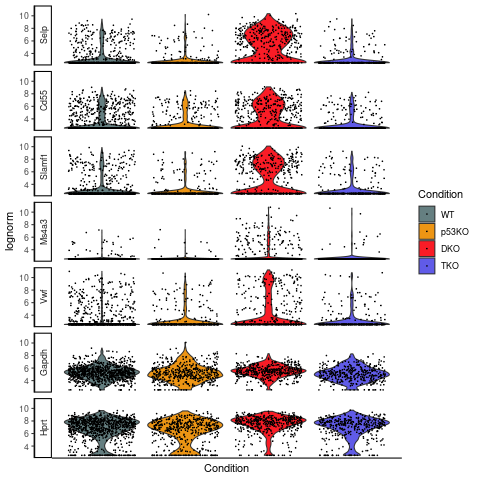

In [76]:
%%R
# Figure6E
genes <- c('Selp', 'Cd55', 'Slamf1', 'Ms4a3', 'Vwf', 'Gapdh', 'Hprt')
con <- c('WT', 'p53KO', 'DKO', 'TKO')
violin_patel(lognorm, genes, con, ncol=1,FN="Fig5b.pdf")

In [46]:
def umap_split(adata, geneID, cond=['WT', 'p53KO', 'DKO', 'TKO'], save=True):
    fig, ax = plt.subplots(1,4,figsize=(12,3.2), sharex=True, sharey=True)
    for i in range(len(cond)):
        sc.pl.umap(adata[adata.obs.Condition==cond[i]],size=40, color=geneID, title=cond[i], color_map=cmap, vmax=10,ax=ax[i], show=False)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2)
    if save:
        plt.savefig('Umap_split_'+geneID+'.pdf', bbox_inches='tight')

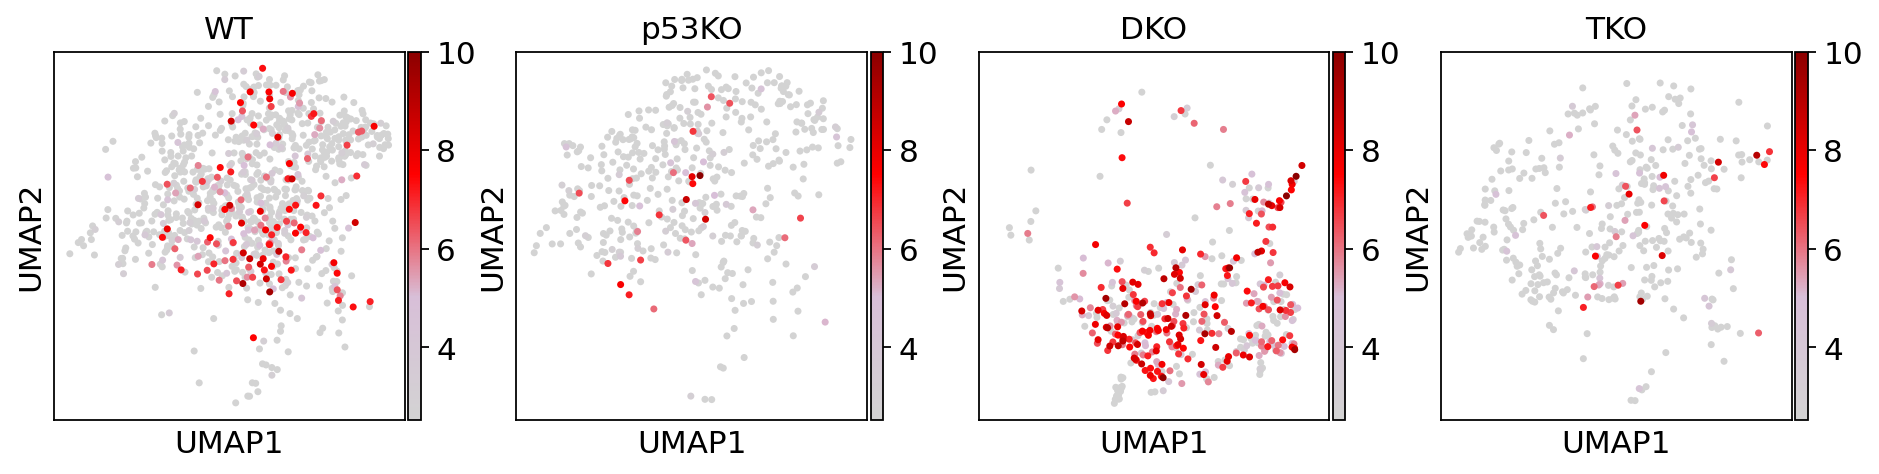

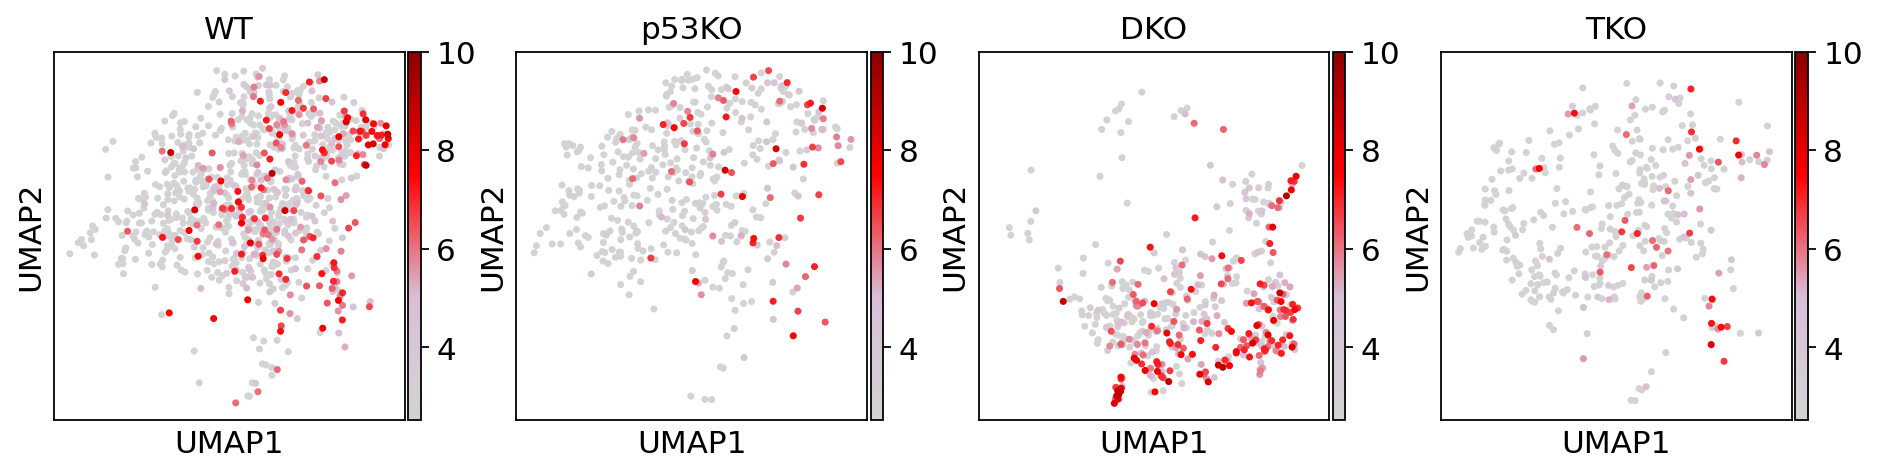

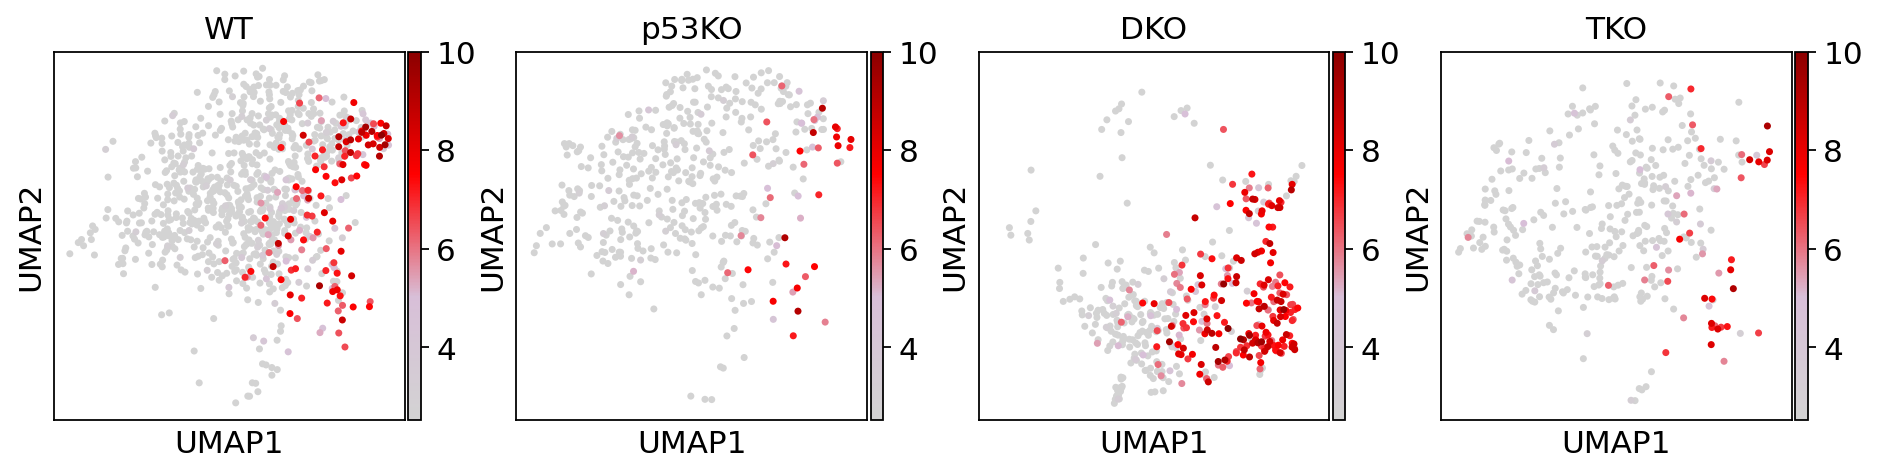

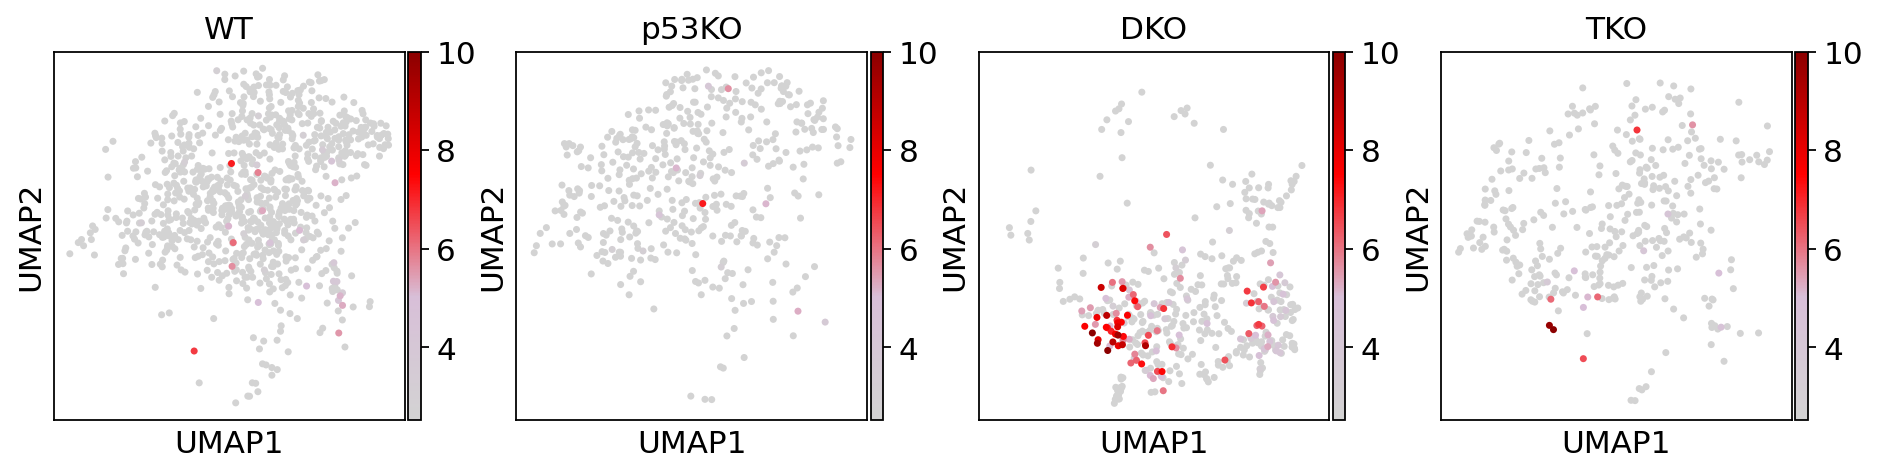

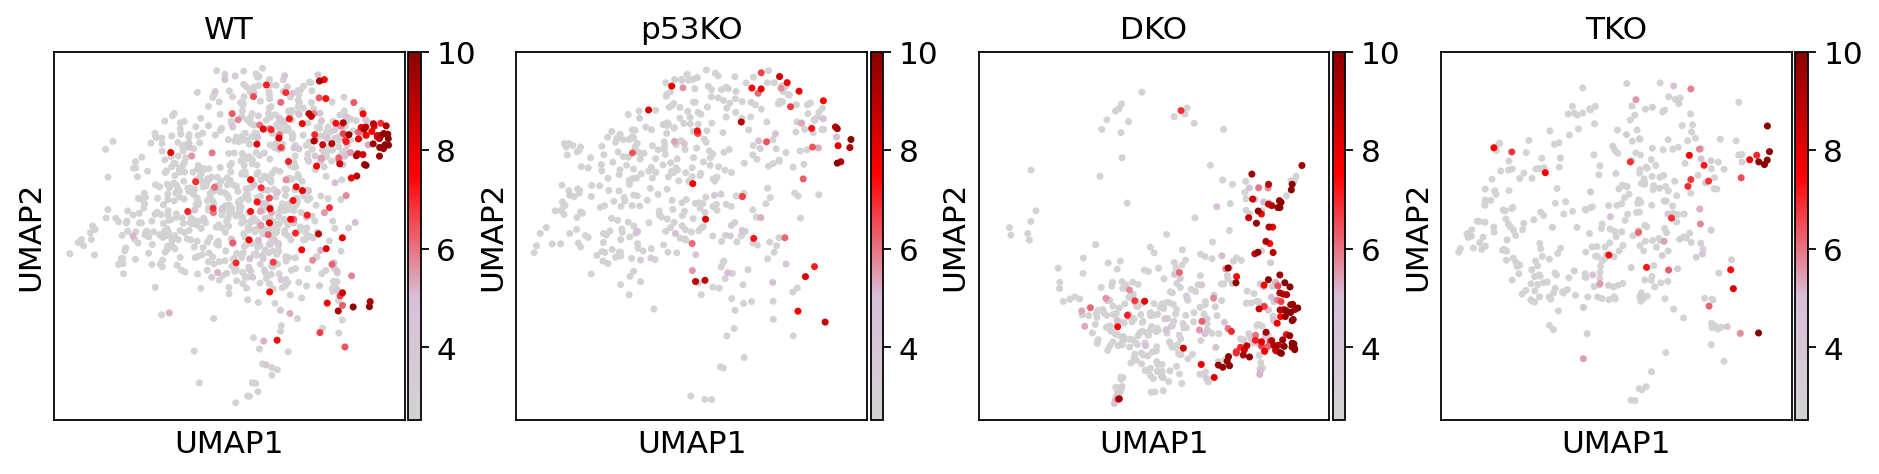

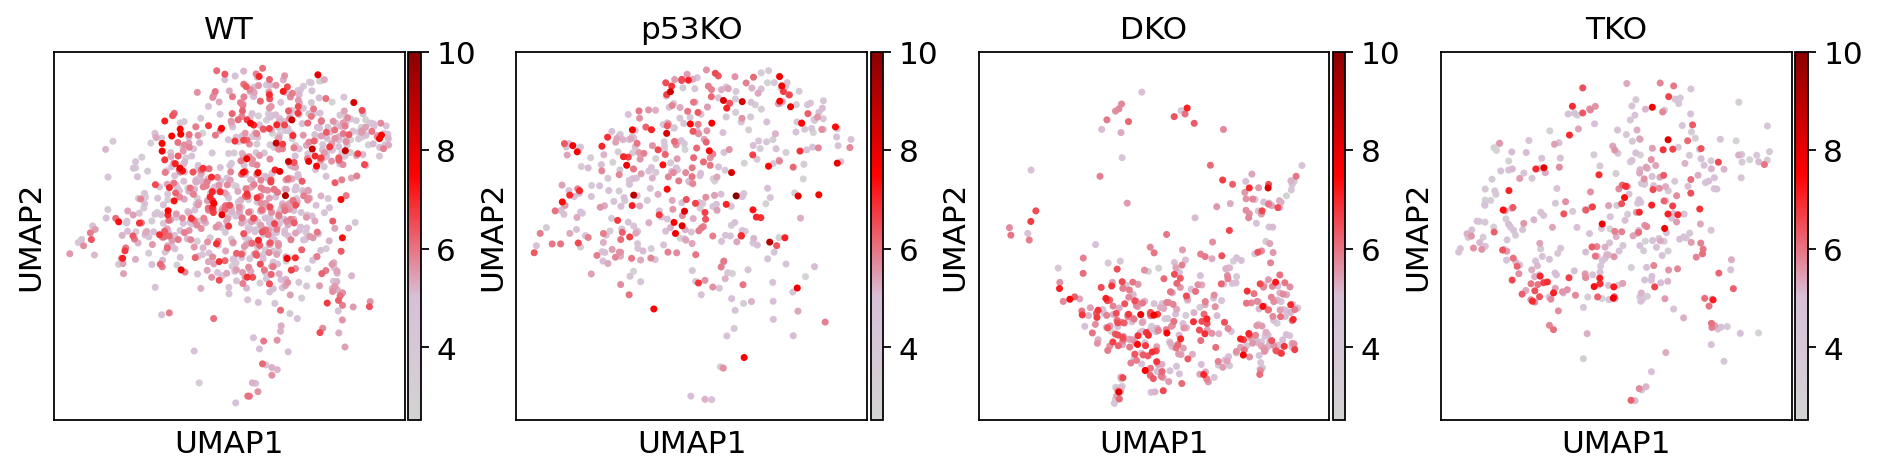

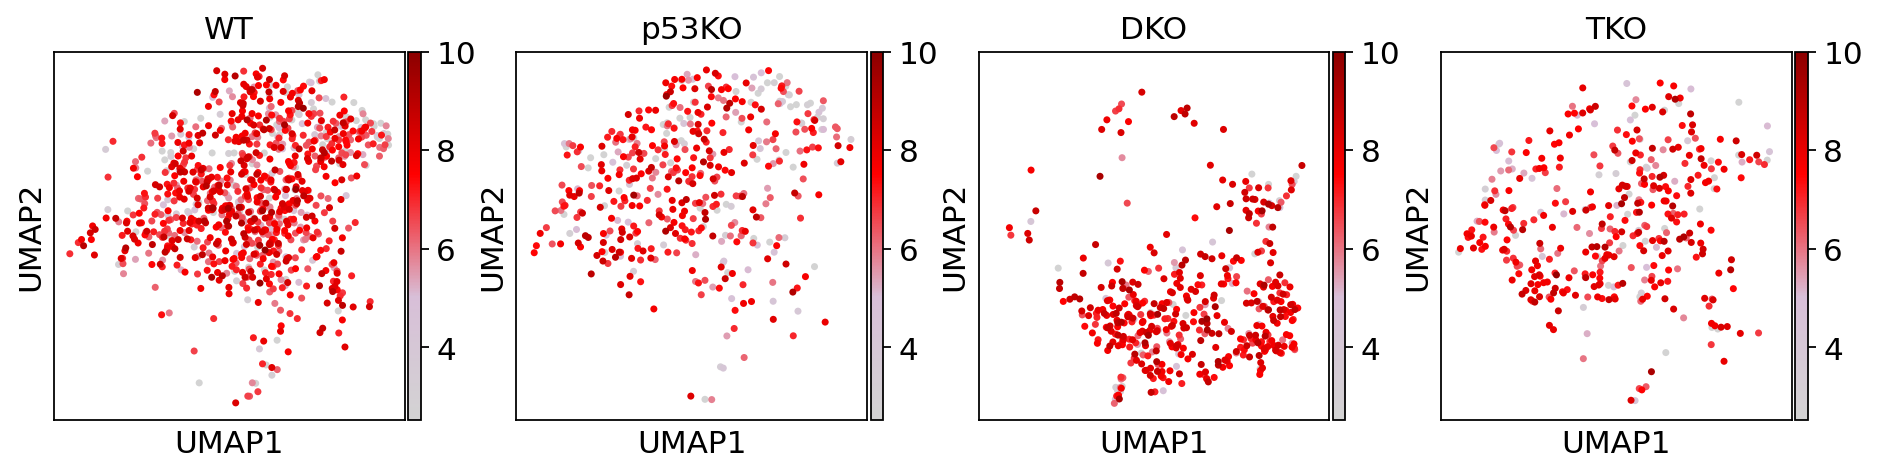

In [104]:
# Figure6E left
GL = ['Selp', 'Cd55', 'Slamf1', 'Ms4a3', 'Vwf', 'Gapdh', 'Hprt']
for i in GL:
    umap_split(adata, geneID=i)

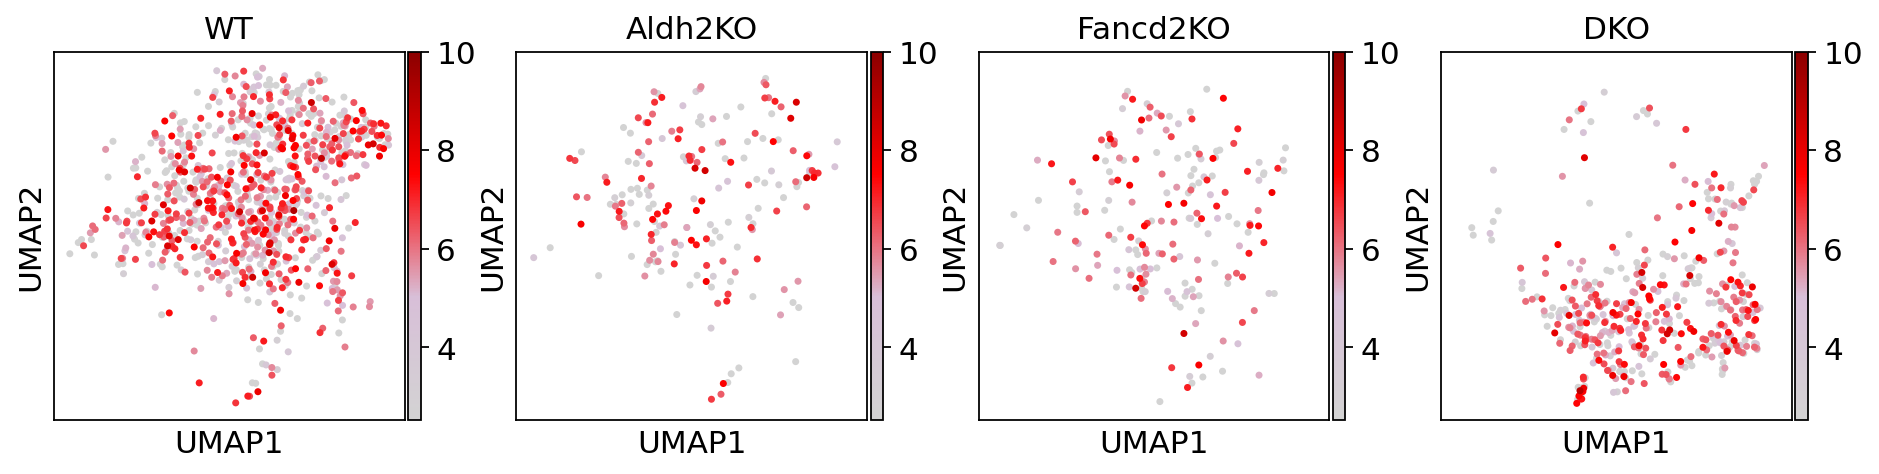

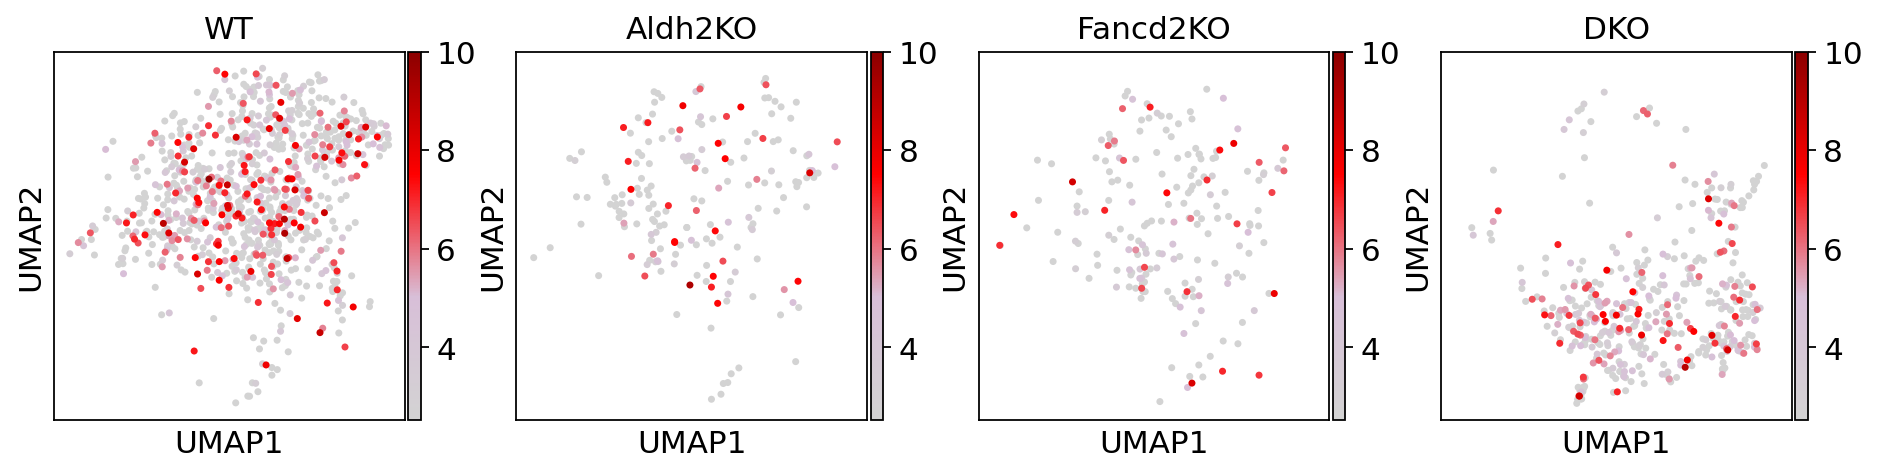

In [48]:
# FigureS3A left + FigureS3B left
GL = ['Batf', 'Per2']
for i in GL:
    umap_split(adata, geneID=i, cond=['WT', 'Aldh2KO', 'Fancd2KO', 'DKO'])

Gene expression in LTHSC

In [50]:
adata_LTHSC = adata_norm[adata_norm.obs['Combined_CT'] == 'LTHSC'].copy()

In [51]:
lognorm = adata_LTHSC.X
meta = adata_LTHSC.obs
GN = adata_LTHSC.var_names

In [52]:
%%R -i lognorm -i meta -i GN
rownames(lognorm) = meta$Condition
colnames(lognorm) = GN

[1] 226  10
  Condition Gene  lognorm
1        WT Per2 7.705043
2        WT Per2 2.525719
3        WT Per2 2.525719
4        WT Per2 2.525719
5        WT Per2 3.202149
6        WT Per2 2.525719


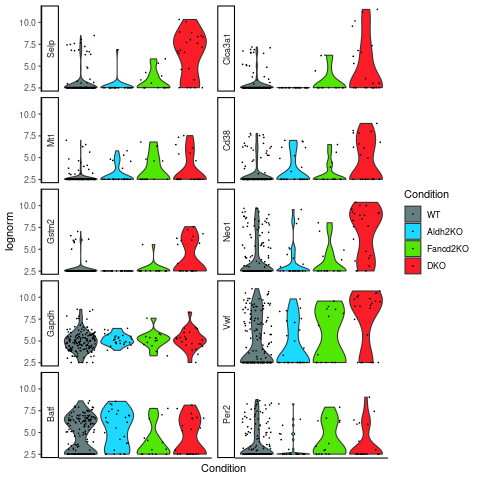

In [53]:
%%R
# Figure2C + Figure7A + FigureS3A right + FigureS3B right
genes <- c('Selp', 'Clca3a1', 'Mt1', 'Cd38', 'Gstm2', 'Neo1', 'Gapdh', 'Vwf', 'Batf', 'Per2')
con <- c('WT', 'Aldh2KO', 'Fancd2KO', 'DKO')
violin_patel(lognorm, genes, con, ncol=2)

[1] 289   7
  Condition Gene  lognorm
1        WT Selp 2.525719
2        WT Selp 2.525719
3        WT Selp 2.525719
4        WT Selp 2.525719
5        WT Selp 7.418725
6        WT Selp 2.525719


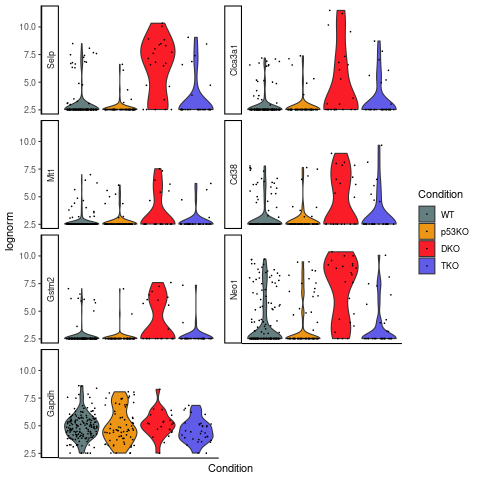

In [14]:
%%R
# FigureS4A
genes <- c('Selp', 'Clca3a1', 'Mt1', 'Cd38', 'Gstm2', 'Neo1', 'Gapdh')
con <- c('WT', 'p53KO', 'DKO', 'TKO')
violin_patel(lognorm, genes, con, ncol=2)

Gene Expression in LSK

In [64]:
lognorm = adata_norm.X
meta = adata_norm.obs
GN = adata_norm.var_names

In [65]:
%%R -i lognorm -i meta -i GN
rownames(lognorm) = meta$Condition
colnames(lognorm) = GN

[1] 1722    6
  Condition Gene  lognorm
1        WT Per2 3.047574
2        WT Per2 7.705043
3        WT Per2 2.525719
4        WT Per2 2.525719
5        WT Per2 2.525719
6       DKO Per2 2.525719


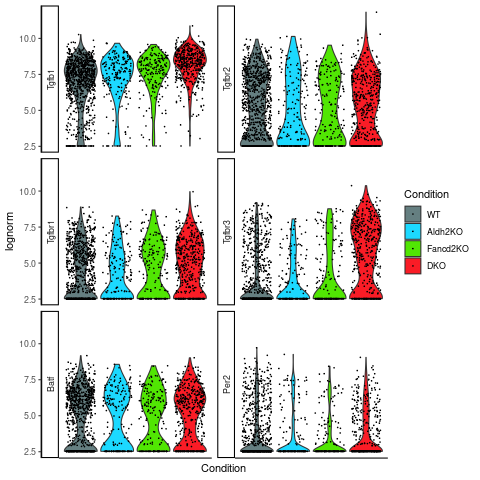

In [56]:
%%R
# FigureS2C + FigureS3A right + FigureS3B right
genes <- c('Tgfb1', 'Tgfbr2', 'Tgfbr1', 'Tgfbr3', 'Batf', 'Per2')
con <- c('WT', 'Aldh2KO', 'Fancd2KO', 'DKO')
violin_patel(lognorm, genes, con, ncol=2) 

[1] 2554    4
  Condition  Gene   lognorm
1        WT Aldh2  9.572032
2        WT Aldh2  9.386090
3        WT Aldh2 10.133137
4        WT Aldh2  9.040689
5        WT Aldh2  9.950998
6       DKO Aldh2  4.002866


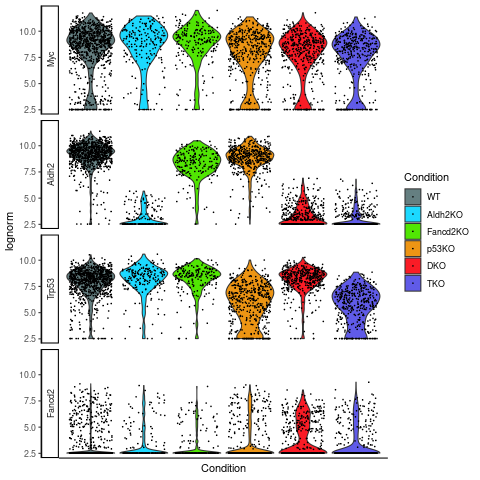

In [69]:
%%R
# FigureS5D
genes <- c('Myc', 'Aldh2', 'Trp53', 'Fancd2')
con <- c('WT', 'Aldh2KO', 'Fancd2KO', 'p53KO', 'DKO', 'TKO')
violin_patel(lognorm, genes, con, ncol=1) 

Gene Expression in LMPP

In [57]:
adata_LMPP = adata_norm[adata_norm.obs['Combined_CT'] == 'LMPP'].copy()

In [58]:
lognorm = adata_LMPP.X
meta = adata_LMPP.obs
GN = adata_LMPP.var_names

In [59]:
%%R -i lognorm -i meta -i GN
rownames(lognorm) = meta$Condition
colnames(lognorm) = GN

[1] 401   2
  Condition Gene  lognorm
1        WT Per2 2.525719
2        WT Per2 2.525719
3        WT Per2 8.326353
4        WT Per2 2.525719
5        WT Per2 2.525719
6        WT Per2 2.525719


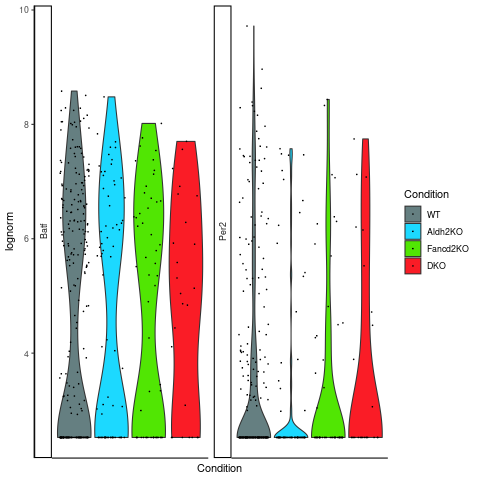

In [60]:
%%R
# FigureS3A right + FigureS3B right
genes <- c('Batf', 'Per2')
con <- c('WT', 'Aldh2KO', 'Fancd2KO', 'DKO')
violin_patel(lognorm, genes, con, ncol=2) 

# Generate input for the agingsignature website

https://agingsignature.webhosting.rug.nl/sc_form \
generate input for the ageing website from Svendsen et al. 2021 Blood.

In [104]:
# raw
# row: gene symbols
# col: single cells
# 1st row: group
adata_raw = sc.read('./write/patel_smq2_LSK_raw.h5ad')
adata_norm = sc.read('./write/lognorm_edgeR.h5ad')
adata_raw.obs = adata_norm.obs
adata_raw = adata_raw[:,adata_norm.var_names].copy()

In [118]:
L1 = adata_raw[(adata_raw.obs['Combined_CT'] == 'LTHSC') & np.in1d(adata_raw.obs['Condition'], ['WT','Fancd2KO','Aldh2KO', 'DKO']),].copy()
L2 = adata_raw[(adata_raw.obs['Combined_CT'] == 'LTHSC') & np.in1d(adata_raw.obs['Condition'], ['WT', 'p53KO', 'DKO', 'TKO']),].copy()

In [119]:
sc.pp.filter_genes(L1, min_cells=1)
sc.pp.filter_genes(L2, min_cells=1)

filtered out 26 genes that are detected in less than 1 cells
filtered out 21 genes that are detected in less than 1 cells


In [120]:
L1DF = pd.DataFrame(L1.X.T.astype(int), columns=L1.obs_names, index=L1.var_names)
L2DF = pd.DataFrame(L2.X.T.astype(int), columns=L2.obs_names, index=L2.var_names)
print(L1DF.shape)
print(L2DF.shape)

(13964, 226)
(13969, 289)


In [122]:
L1DF = pd.concat([L1.obs[['Condition']].T, L1DF], axis=0)
L2DF = pd.concat([L1.obs[['Condition']].T, L2DF], axis=0)
print(L1DF.shape)
print(L2DF.shape)

(13965, 226)
(13970, 330)


In [126]:
L1DF = L1DF.rename(index={'Condition': 'ID'})
L2DF = L2DF.rename(index={'Condition': 'ID'})

In [127]:
L1DF.head()

RBG25050 RBG25065 RBG25073 RBG25074 RBG25076 RBG25082 RBG25083  \
ID            WT       WT       WT       WT       WT       WT       WT   
Mrpl15        23       41       59      107       28        0        0   
Lypla1         0        0        0        4        1       25        6   
Tcea1          2       22        0       14        0       12        0   
Atp6v1h        1        1       72       42        0        0       64   

        RBG25086 RBG25087 RBG25095  ... RBG32512 RBG32513 RBG32520 RBG32523  \
ID            WT       WT       WT  ...       WT       WT       WT       WT   
Mrpl15         3       49       38  ...       19       10        0        6   
Lypla1         0        0        0  ...        1        3        0        1   
Tcea1          1        1        0  ...        2        1        0       11   
Atp6v1h       43        0       41  ...       20       43        6       14   

        RBG32525 RBG32535 RBG32548 RBG32559 RBG32581 RBG32582  
ID            WT       WT       WT       WT       WT       WT  
Mrpl15        12       34       11       75        4        9  
Lypla1         3        8        5       14        7        0  
Tcea1          2       16        2        4        2        7  
Atp6v1h       19       33        9       57       45        3  

[5 rows x 226 columns]

In [130]:
L1DF.to_csv('L1DF.csv', sep='\t', header=None)
L2DF.to_csv('L2DF.csv', sep='\t', header=None)

## p53 score

In [2]:
adata = sc.read('./write/lognorm_edgeR.h5ad')
adata.raw=adata

In [3]:
adata = adata[np.in1d(adata.obs['Combined_CT'], ['LTHSC', 'STHSC', 'MPP', 'LMPP', 'GMP', 'MEP'])].copy()

In [4]:
p53_targets = pd.read_csv('/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Lab_Members/Niki/Patel_SMQ2/Analysis_26Jun2020/Laura_p53_Targets.txt', sep='\t')
print(p53_targets.shape)
p53_targets = p53_targets['Human Gene Symbol'].values
p53_targets = [x[0].upper()+x[1:].lower() for x in p53_targets]
p53_targets = np.intersect1d(p53_targets, adata.raw.var_names)
print(len(p53_targets))

(150, 5)
113


In [5]:
# Define colors
c = {'WT': '#657F81',
    'Aldh2KO': '#1CD9FF',
    'Fancd2KO': '#51E603',
    'DKO':'#FA1C26',
    'TKO': '#605BE8',
    'p53KO':'#ED9514'}

In [6]:
adata.uns['Condition_colors'] = [c[x] for x in adata.obs['Condition'].cat.categories]

In [33]:
DataIn = pd.DataFrame(adata.raw[:,p53_targets].X)
MetaIn = adata.obs[['Combined_CT', 'Condition']]
GNIn = p53_targets
CNIn = adata.obs_names
Col_CT = pd.DataFrame([adata.obs['Combined_CT'].cat.categories, adata.uns['Combined_CT_colors']]).T
Col_Con = pd.DataFrame([adata.obs['Condition'].cat.categories, adata.uns['Condition_colors']]).T

[1] 113  36
[1] 36
LTHSC STHSC   MPP  LMPP   GMP   MEP 
    6    12    18    24    30    36 
[1] 6
[1] 6


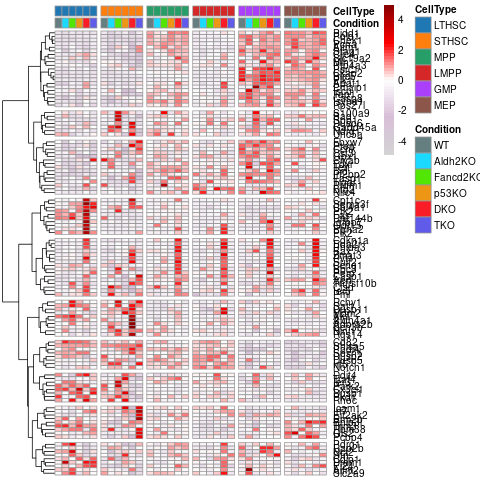

In [36]:
%%R -i DataIn -i MetaIn -i GNIn -i CNIn -i Col_CT -i Col_Con
# FigureS5A
library(pheatmap)
colnames(DataIn) <- GNIn
rownames(DataIn) <- CNIn

MetaIn$cb = paste(MetaIn$Combined_CT, MetaIn$Condition, sep="_")
mat =t(apply(DataIn, 2, function(x){
    tapply(x, MetaIn$cb, mean)
}))
print(dim(mat))

CT = Col_CT[,2]
names(CT) = Col_CT[,1]

Con = Col_Con[,2]
names(Con) = Col_Con[,1]

CN = sapply(names(CT), function(x){
    sapply(names(Con), function(y){
        paste(x,"_",y, sep="")
    })
})
print(length(CN))
mat = mat[,CN[CN %in% colnames(mat)]]
#print(colnames(mat))

CTV <- factor(gsub("(.*)_.*", "\\1", colnames(mat)), levels=names(CT))
ConV <- factor(gsub(".*_(.*)", "\\1", colnames(mat)), levels=names(Con))
breaks <- cumsum(table(CTV))
print(breaks)

annotation_col = data.frame( Condition=ConV,CellType=CTV)
rownames(annotation_col) <- colnames(mat)
print(length(levels(ConV)))
print(length(levels(CTV)))
ann_colors = list(
                  Condition = Con,
                  CellType = CT
                 )

color = colorRampPalette(c('lightgrey', 'thistle','white', 'red', 'darkred'))(50)

p <- pheatmap(mat, cutree_rows=10,clustering_method="ward.D2", annotation_col = annotation_col, annotation_colors=ann_colors, scale="row", cluster_cols=FALSE, color=color, show_rownames=T, show_colnames=F, gaps_col=breaks)
p
pheatmap(mat, cutree_rows=10,clustering_method="ward.D2", annotation_col = annotation_col, annotation_colors=ann_colors, scale="row", cluster_cols=FALSE, color=color, show_rownames=T, show_colnames=F, gaps_col=breaks, filename="Supp_Fig4.pdf", width=8, height=14)

In [7]:
ctchange = {
    'LTHSC': 'HSC',
    'STHSC': 'HSC'
}

In [8]:
adata.obs['Combined_CT_new'] = [ctchange[x] if x in ctchange.keys() else x for x in adata.obs['Combined_CT']]
adata.obs['Combined_CT_new'] = adata.obs['Combined_CT_new'].astype('category')
adata.obs['Combined_CT_new'].cat.categories
adata.obs['Combined_CT_new'] = adata.obs['Combined_CT_new'].cat.reorder_categories(['HSC', 'MPP', 'LMPP', 'GMP', 'MEP'])

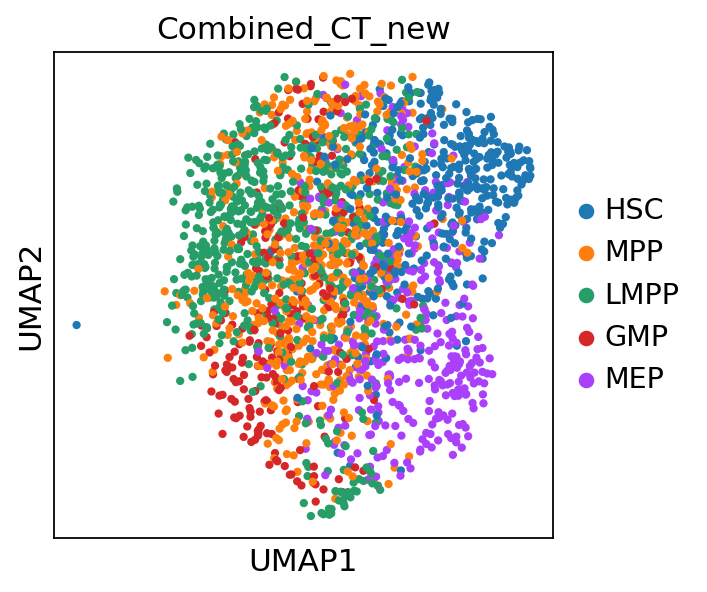

In [10]:
sc.pl.umap(adata, color='Combined_CT_new')

In [12]:
DataIn = pd.DataFrame(adata.raw[:,p53_targets].X)
MetaIn = adata.obs[['Combined_CT_new', 'Condition']]
GNIn = p53_targets
CNIn = adata.obs_names
Col_CT = pd.DataFrame([adata.obs['Combined_CT_new'].cat.categories, adata.uns['Combined_CT_new_colors']]).T
Col_Con = pd.DataFrame([adata.obs['Condition'].cat.categories, adata.uns['Condition_colors']]).T

[1] 113  30
[1] 30
 HSC  MPP LMPP  GMP  MEP 
   6   12   18   24   30 
[1] 6
[1] 5


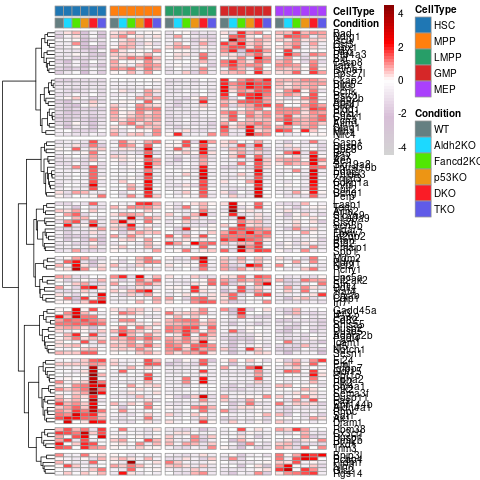

In [14]:
%%R -i DataIn -i MetaIn -i GNIn -i CNIn -i Col_CT -i Col_Con
library(pheatmap)
colnames(DataIn) <- GNIn
rownames(DataIn) <- CNIn

MetaIn$cb = paste(MetaIn$Combined_CT_new, MetaIn$Condition, sep="_")
mat =t(apply(DataIn, 2, function(x){
    tapply(x, MetaIn$cb, mean)
}))
print(dim(mat))

CT = Col_CT[,2]
names(CT) = Col_CT[,1]

Con = Col_Con[,2]
names(Con) = Col_Con[,1]

CN = sapply(names(CT), function(x){
    sapply(names(Con), function(y){
        paste(x,"_",y, sep="")
    })
})
print(length(CN))
mat = mat[,CN[CN %in% colnames(mat)]]
#print(colnames(mat))

CTV <- factor(gsub("(.*)_.*", "\\1", colnames(mat)), levels=names(CT))
ConV <- factor(gsub(".*_(.*)", "\\1", colnames(mat)), levels=names(Con))
breaks <- cumsum(table(CTV))
print(breaks)

annotation_col = data.frame( Condition=ConV,CellType=CTV)
rownames(annotation_col) <- colnames(mat)
print(length(levels(ConV)))
print(length(levels(CTV)))
ann_colors = list(
                  Condition = Con,
                  CellType = CT
                 )

color = colorRampPalette(c('lightgrey', 'thistle','white', 'red', 'darkred'))(50)

p <- pheatmap(mat, cutree_rows=10,clustering_method="ward.D2", annotation_col = annotation_col, annotation_colors=ann_colors, scale="row", cluster_cols=FALSE, color=color, show_rownames=T, show_colnames=F, gaps_col=breaks)
p
pheatmap(mat, cutree_rows=10,clustering_method="ward.D2", annotation_col = annotation_col, annotation_colors=ann_colors, scale="row", cluster_cols=FALSE, color=color, show_rownames=T, show_colnames=F, gaps_col=breaks, filename="Supp_Fig4_new.pdf", width=8, height=14)

Exact LTHSC p53 assocated genes.

In [ ]:
%%R -o p53GL
cluster = cutree(p$tree_row,
    k = 10)
p53GL = names(cluster[cluster==2])
print(p53GL)
print(length(p53GL))
write.table(p53GL, "p53GL.txt", quote=F, row.names=F, col.names=F, sep="\t")

[1] 16 36
[1] 36
LTHSC STHSC   MPP  LMPP   GMP   MEP 
    6    12    18    24    30    36 
[1] 6
[1] 6


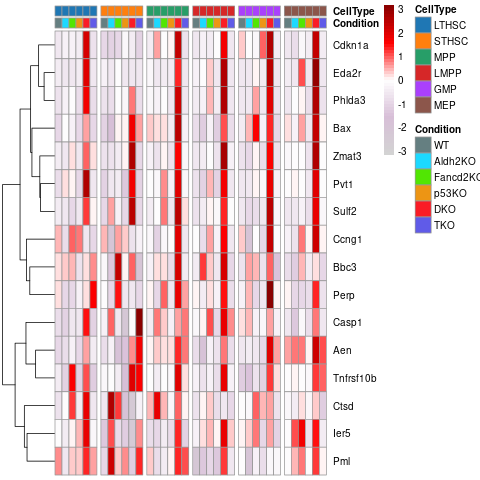

In [110]:
%%R
# Figure5A
p53GL = read.table('../Analysis_17Feb2021/p53GL.txt')[,1]
Datasub = DataIn[,colnames(DataIn) %in% p53GL]

MetaIn$cb = paste(MetaIn$Combined_CT, MetaIn$Condition, sep="_")
mat =t(apply(Datasub, 2, function(x){
    tapply(x, MetaIn$cb, mean)
}))
print(dim(mat))

CT = Col_CT[,2]
names(CT) = Col_CT[,1]

Con = Col_Con[,2]
names(Con) = Col_Con[,1]

CN = sapply(names(CT), function(x){
    sapply(names(Con), function(y){
        paste(x,"_",y, sep="")
    })
})
print(length(CN))
mat = mat[,CN[CN %in% colnames(mat)]]

CTV <- factor(gsub("(.*)_.*", "\\1", colnames(mat)), levels=names(CT))
ConV <- factor(gsub(".*_(.*)", "\\1", colnames(mat)), levels=names(Con))
breaks <- cumsum(table(CTV))
print(breaks)

annotation_col = data.frame( Condition=ConV,CellType=CTV)
rownames(annotation_col) <- colnames(mat)
print(length(levels(ConV)))
print(length(levels(CTV)))
ann_colors = list(
                  Condition = Con,
                  CellType = CT
                 )

color = colorRampPalette(c('lightgrey', 'thistle','white', 'red', 'darkred'))(50)

p <- pheatmap(mat,clustering_method="ward.D2", annotation_col = annotation_col, annotation_colors=ann_colors, scale="row", cluster_cols=FALSE, color=color, show_rownames=T, show_colnames=F, gaps_col=breaks)
p
pheatmap(mat,clustering_method="ward.D2", annotation_col = annotation_col, annotation_colors=ann_colors, scale="row", cluster_cols=FALSE, color=color, show_rownames=T, show_colnames=F, gaps_col=breaks, filename="Fig4a.pdf", width=10, height=6)

# Calculate the p53 score

In [2]:
adata = sc.read('./write/lognorm_edgeR.h5ad')
adata.raw=adata

In [3]:
p53GL = np.genfromtxt('/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Lab_Members/Niki/Patel_SMQ2/Analysis_17Feb2021/p53GL.txt', dtype='str')

In [6]:
sc.pp.scale(adata)
sc.tl.score_genes(adata,np.array(p53GL), score_name = 'p53S', use_raw=False)

computing score 'p53S'
    finished: added
    'p53S', score of gene set (adata.obs).
    699 total control genes are used. (0:00:00)


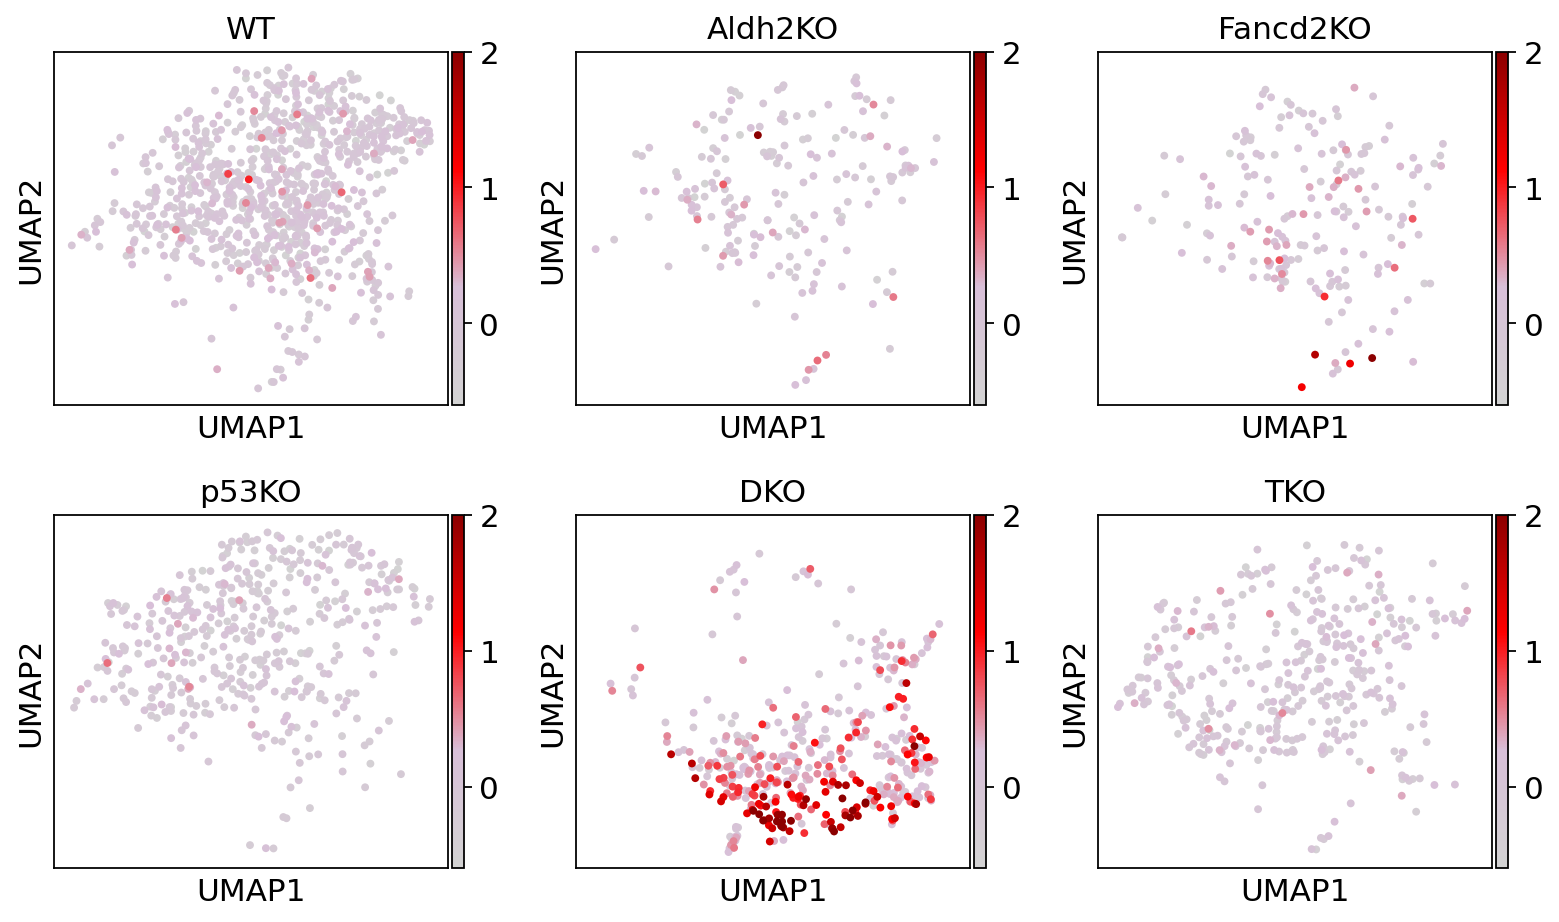

In [8]:
# Figure5D
con = adata.obs['Condition'].cat.categories
fig, axs = plt.subplots(2,3,figsize=(10,6), sharex=True, sharey=True)
for i in range(len(con)):
    ax = axs.flatten()
    sc.pl.umap(adata[adata.obs['Condition'] == con[i]],s=50, title=con[i],color='p53S', color_map=cmap, ax=ax[i], show=False, vmin=-0.6,vmax=2)
plt.tight_layout()

In [16]:
adata.uns['Condition_colors'] = [c[x] for x in adata.obs['Condition'].cat.categories]

DKO v.s. TKO: Mann-Whitney-Wilcoxon test two-sided, P_val=1.205e-58 U_stat=1.390e+05
WT v.s. Aldh2KO: Mann-Whitney-Wilcoxon test two-sided, P_val=9.453e-03 U_stat=7.468e+04
Fancd2KO v.s. DKO: Mann-Whitney-Wilcoxon test two-sided, P_val=1.411e-19 U_stat=2.321e+04
WT v.s. Fancd2KO: Mann-Whitney-Wilcoxon test two-sided, P_val=6.676e-13 U_stat=5.740e+04
WT v.s. p53KO: Mann-Whitney-Wilcoxon test two-sided, P_val=1.124e-02 U_stat=2.206e+05
WT v.s. DKO: Mann-Whitney-Wilcoxon test two-sided, P_val=3.016e-93 U_stat=6.252e+04


(<AxesSubplot:title={'center':'LSK'}, ylabel='p53S'>,
  <statannot.StatResult.StatResult at 0x2ae9b33d4f10>])

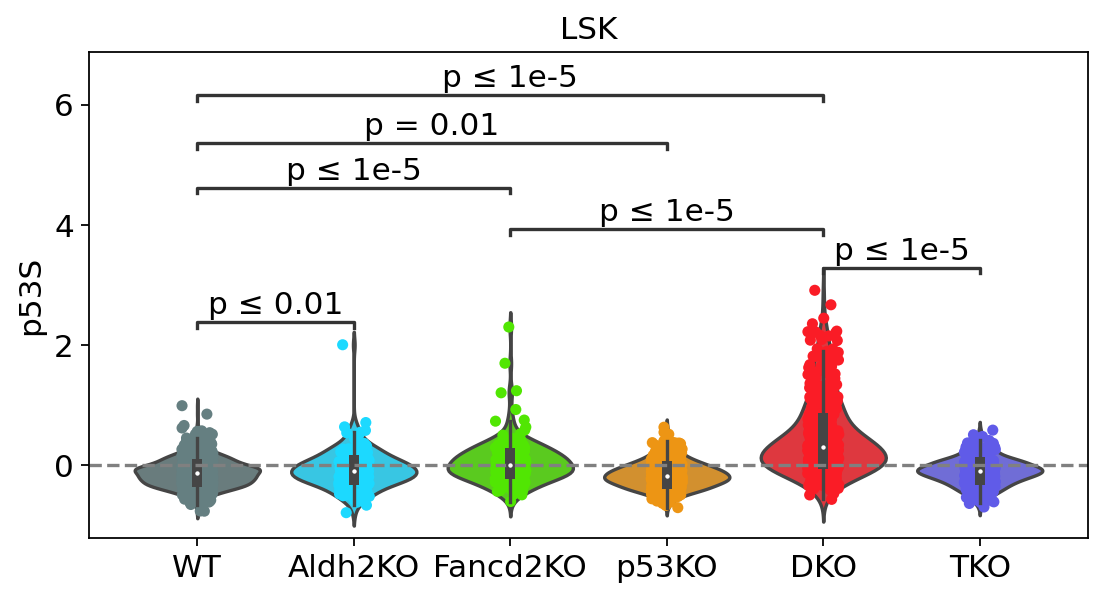

In [28]:
# Figure5C
from statannot import add_stat_annotation
import seaborn as sns
fig, ax = plt.subplots(figsize=(8,4))
sns.violinplot(x='Condition', y='p53S', data=adata.obs[['p53S', 'Condition']],  scale='width', ax=ax, palette=adata.uns['Condition_colors'])
sns.stripplot(x="Condition", y="p53S", data=adata.obs[['p53S', 'Condition']], jitter=True, zorder=1, color=".3", palette=adata.uns['Condition_colors'])
ax.grid(False)
ax.set_xlabel('')
ax.set_title('LSK')
ax.axhline(y=0, linestyle="--", c='grey')
add_stat_annotation(ax, data=adata.obs[['p53S', 'Condition']], x='Condition', y='p53S',
                        box_pairs=[('Fancd2KO', 'DKO'), ('WT', 'DKO'), ('DKO', 'TKO'), ('WT', 'p53KO'), ('WT', 'Fancd2KO'), ('WT', 'Aldh2KO')],
                        test='Mann-Whitney', text_format='simple', loc='inside', verbose=2, comparisons_correction=None)

LTHSC
[array(['Aldh2KO', 'WT'], dtype='<U7'), array(['DKO', 'WT'], dtype='<U3'), array(['Fancd2KO', 'WT'], dtype='<U8'), array(['TKO', 'WT'], dtype='<U3'), array(['p53KO', 'WT'], dtype='<U5')]
WT v.s. Aldh2KO: Mann-Whitney-Wilcoxon test two-sided, P_val=4.042e-01 U_stat=1.967e+03
WT v.s. Fancd2KO: Mann-Whitney-Wilcoxon test two-sided, P_val=3.412e-02 U_stat=7.460e+02
WT v.s. p53KO: Mann-Whitney-Wilcoxon test two-sided, P_val=5.148e-01 U_stat=6.060e+03
WT v.s. DKO: Mann-Whitney-Wilcoxon test two-sided, P_val=9.198e-07 U_stat=6.830e+02
WT v.s. TKO: Mann-Whitney-Wilcoxon test two-sided, P_val=2.634e-01 U_stat=2.342e+03
STHSC
[array(['Aldh2KO', 'WT'], dtype='<U7'), array(['DKO', 'WT'], dtype='<U3'), array(['Fancd2KO', 'WT'], dtype='<U8'), array(['TKO', 'WT'], dtype='<U3'), array(['p53KO', 'WT'], dtype='<U5')]
WT v.s. Aldh2KO: Mann-Whitney-Wilcoxon test two-sided, P_val=1.289e-02 U_stat=1.250e+02
WT v.s. Fancd2KO: Mann-Whitney-Wilcoxon test two-sided, P_val=1.923e-01 U_stat=1.290e+02
WT v.s

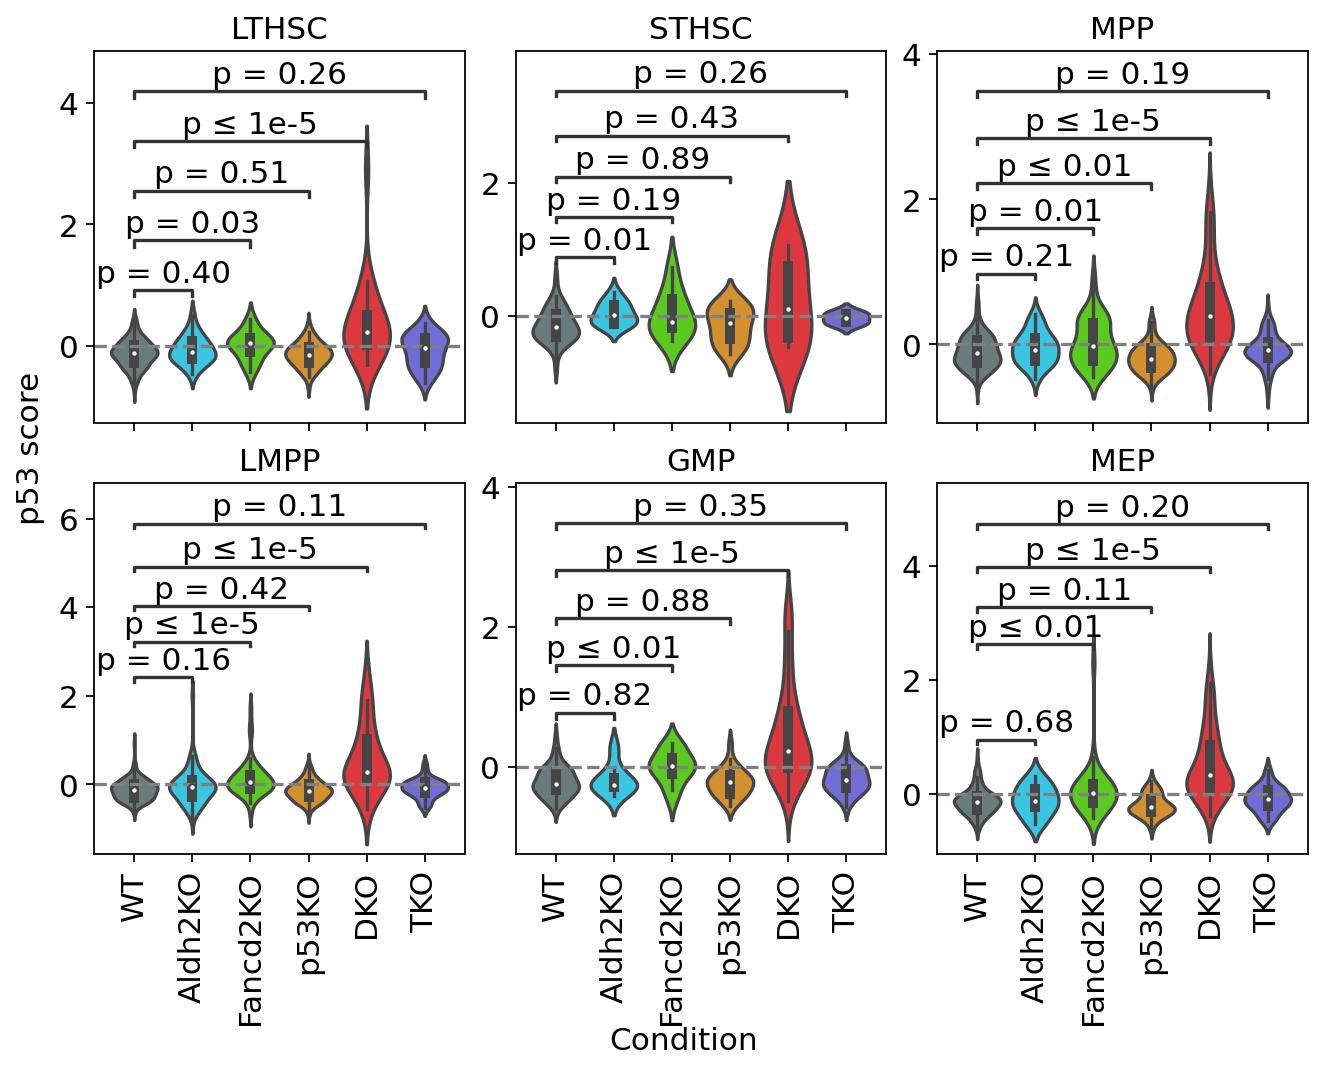

In [63]:
# FigureS5B
from statannot import add_stat_annotation
import seaborn as sns
cat = adata.obs['Combined_CT'].cat.categories[0:6]
fig, ax = plt.subplots(2,3, figsize=(8,6.5), squeeze=False, sharex=True)
for i in range(len(cat)):
    colidx = i%3
    rowidx = np.floor(i/3).astype(int)
    print(cat[i])
    idx = adata.obs['Combined_CT'] == cat[i]
    df = adata[idx,:].obs[['p53S', 'Condition']]
    bp = df['Condition'].astype('category')
    bp = list(bp.cat.categories)
    bp = np.setdiff1d(bp, "WT")
    bpall = []
    for j in bp:
        bpall.append(np.array([j, "WT"]))
    print(bpall)
    sns.violinplot(x='Condition', y='p53S', scale='width', data=df, palette=adata.uns['Condition_colors'],ax=ax[rowidx][colidx])
    ax[rowidx][colidx].grid(False)
    ax[rowidx][colidx].set_title(cat[i])
    ax[rowidx][colidx].set_xlabel('')
    ax[rowidx][colidx].set_ylabel('')
    ax[rowidx][colidx].axhline(0, linestyle='--', color='grey')
    ax[rowidx][colidx].set_xticklabels(labels=df['Condition'].cat.categories,rotation=90)
    add_stat_annotation(ax[rowidx][colidx], data=df, x='Condition', y='p53S',
                        box_pairs=bpall,comparisons_correction=None,
                        test='Mann-Whitney', text_format='simple', loc='inside', verbose=2)

fig.text(0.5, -0.01, 'Condition', ha='center')
fig.text(-0.01, 0.5, 'p53 score', ha='center', rotation='vertical')

# for i in [11]:
#     fig.delaxes(ax.flatten()[i])
    
plt.tight_layout(pad=0.5)

In [6]:
# find genes that correlated with p53score
cor_save = np.array([])
for c in adata.raw.X.T:
    cs = np.corrcoef(adata.obs['p53S'], c)[0,1]
    cor_save = np.append(cor_save, cs)

In [7]:
corTable = pd.DataFrame(cor_save, columns=['pearsonCor'], index=adata.raw.var_names)
corTable = corTable.sort_values('pearsonCor', ascending=False)

In [19]:
corTable.to_csv('PearsonCor.csv')

In [28]:
corTable = pd.read_csv('../Analysis_17Feb2021/PearsonCor.csv', index_col=0)

In [29]:
corsub = corTable.iloc[0:46,].copy()

In [44]:
idx = np.in1d(corsub.index,p53_targets)
geneB = corsub.iloc[0:46,].index[idx]
print(geneB)
print(len(geneB))
corsub['Type'] = ['Known' if x==True else 'Novel' for x in idx]

Index(['Phlda3', 'Zmat3', 'Eda2r', 'Cdkn1a', 'Pvt1', 'Sulf2', 'Epha2', 'Bax',
       'Cpt1c', 'Bbc3', 'Ccng1', 'Aen', 'Tnfrsf10b', 'Perp', 'Rps27l', 'Ier5',
       'Plk2', 'Psrc1', 'Gdf15', 'Slc19a2', 'Pmaip1', 'Pml', 'Ctsd'],
      dtype='object')
23


In [52]:
corsub.head()

pearsonCor   Type
Phlda3    0.642393  Known
Zmat3     0.602112  Known
Eda2r     0.598296  Known
Cdkn1a    0.591398  Known
Pvt1      0.526077  Known

['Known' 'Novel']


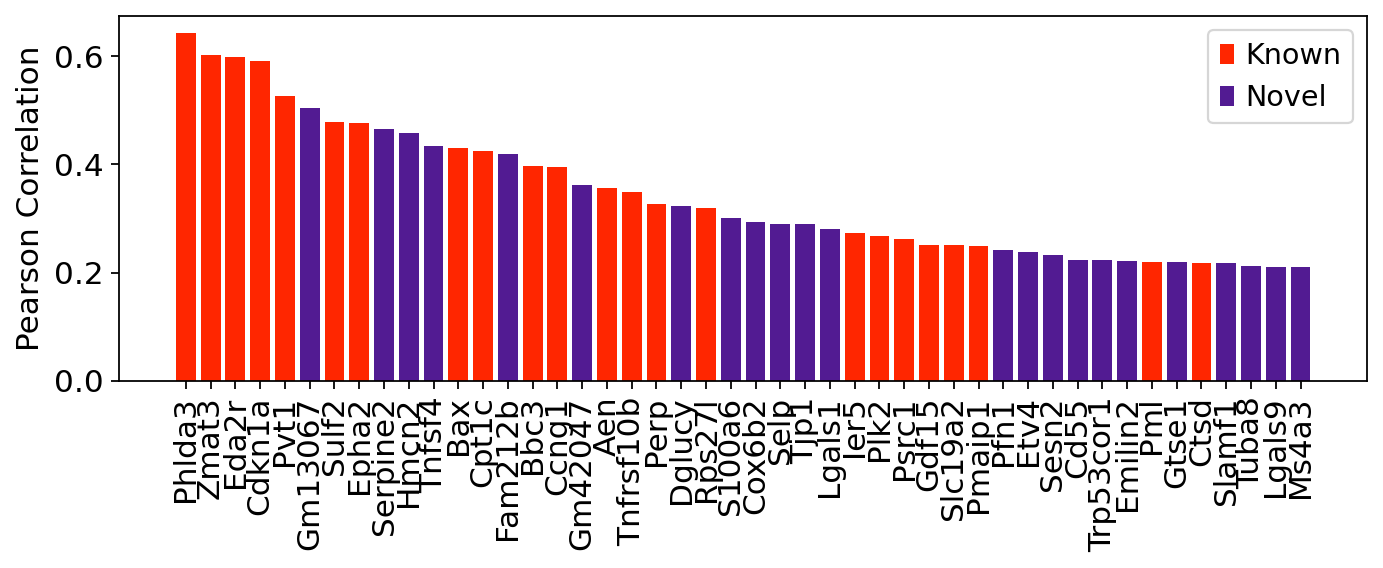

In [75]:
# Figure6D
fig, ax = plt.subplots(figsize=(10,3))
cat = np.unique(corsub['Type'])
print(cat)
col = ['#ff2600', '#521b92']
for i in range(len(cat)):
    idx = np.in1d(corsub['Type'], cat[i])
    ax.bar(np.array(range(46))[idx], corsub['pearsonCor'][idx], color=col[i], label=cat[i])
ax.grid(False)
ax.set_xticks(range(46))
ax.set_xticklabels(corsub.index, rotation=90)
ax.set_ylabel('Pearson Correlation')
ax.legend()
plt.savefig('Fig5a.pdf', bbox_inches='tight')

# Inflammation Signature

In [94]:
adata = sc.read('./write/lognorm_edgeR.h5ad')
adata.raw = adata

In [95]:
infla_sig = np.genfromtxt('mann_genes.txt', dtype=str)
infla_sig = np.intersect1d(infla_sig, adata.raw.var_names)
print(infla_sig)
print(len(infla_sig))

['AW112010' 'Acap1' 'Acsl1' 'Adipor2' 'Adrb2' 'Aldoa' 'Bfsp2' 'Bin2'
 'Car2' 'Ccdc149' 'Ccl3' 'Ccnd2' 'Cd47' 'Cd9' 'Cdkn1a' 'Cmpk2' 'Coro1a'
 'Creg1' 'Cstb' 'Cx3cl1' 'Cxcl16' 'Cxcr4' 'Ddx58' 'Dtx3l' 'Eif3j2'
 'Fcer2a' 'Fdps' 'Ftl1' 'Gclm' 'Glipr1' 'H2-Q7' 'H2afy' 'Herpud1' 'Hmgcs1'
 'Hmox1' 'Hspa8' 'Ifi203' 'Ifi44' 'Ifi47' 'Ifih1' 'Ifitm1' 'Ifitm3'
 'Inpp5d' 'Irf7' 'Isg15' 'Isg20' 'Ivns1abp' 'Klf13' 'Lamtor2' 'Lgals9'
 'Lims1' 'Litaf' 'Ltb' 'Map2k3' 'Mbnl1' 'Mif' 'Mknk2' 'Mndal' 'Mrps6'
 'Nadk' 'Nars' 'Nfkbia' 'Nt5c3' 'Oasl1' 'Park7' 'Pmepa1' 'Pnp' 'Prr13'
 'Psmb8' 'Psmb9' 'Psme1' 'Psme2' 'Relb' 'Rgcc' 'Riok3' 'Rpl24' 'Sbds'
 'Sephs2' 'Serp1' 'Serpina3g' 'Slc38a2' 'Slc5a3' 'Sp100' 'Sp110' 'Sp140'
 'Spp1' 'Sqstm1' 'Srgn' 'Stap1' 'Taldo1' 'Tgtp2' 'Tmem176b' 'Tmem38b'
 'Tpi1' 'Trp53inp2' 'Uba7' 'Vmp1' 'Xaf1' 'Zfp36l1']
99


In [96]:
adata = adata[np.in1d(adata.obs.Condition, ['WT', 'Aldh2KO', 'Fancd2KO', 'DKO'])].copy()

['12', '29', '16', '31', '68', '69', '70', '71', '35', '93', '55', '64', '48', '14', '49', '87', '94', '98', '6', '73', '28', '96', '83', '89', '75', '60', '78', '59', '66', '81', '92', '18', '58', '32', '38', '77', '21', '51', '24', '46', '80', '26', '33', '53', '50', '85', '56', '74', '54', '30', '7', '8', '17', '62', '13', '79', '91', '40', '41', '20', '45', '39', '90', '95', '22', '97', '37', '43', '15', '44', '63', '36', '57', '23', '82', '27', '34', '5', '11', '86', '10', '52', '4', '42', '9', '65', '2', '47', '0', '3', '76', '1', '88', '84', '61', '72', '25', '19', '67']


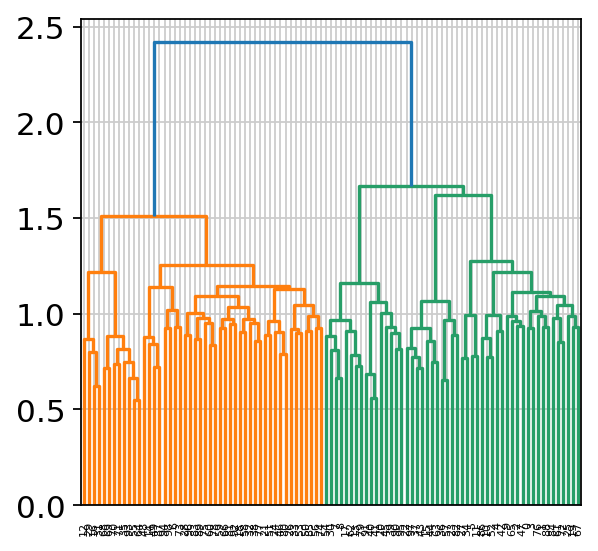

In [109]:
# first group the genes then plot dotplot
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
D_sub = pd.DataFrame(adata.raw[:,infla_sig].X)
D_sub.columns = infla_sig
D_sub.index = adata.obs_names

c2 = D_sub.corr().values
c2_dist = sp.distance.squareform(1-c2)
h2 = hc.linkage(c2_dist, method='ward')
Gordered = hc.dendrogram(h2)['ivl']
print(Gordered)
Gordered = np.array(infla_sig)[[int(x) for x in Gordered]]

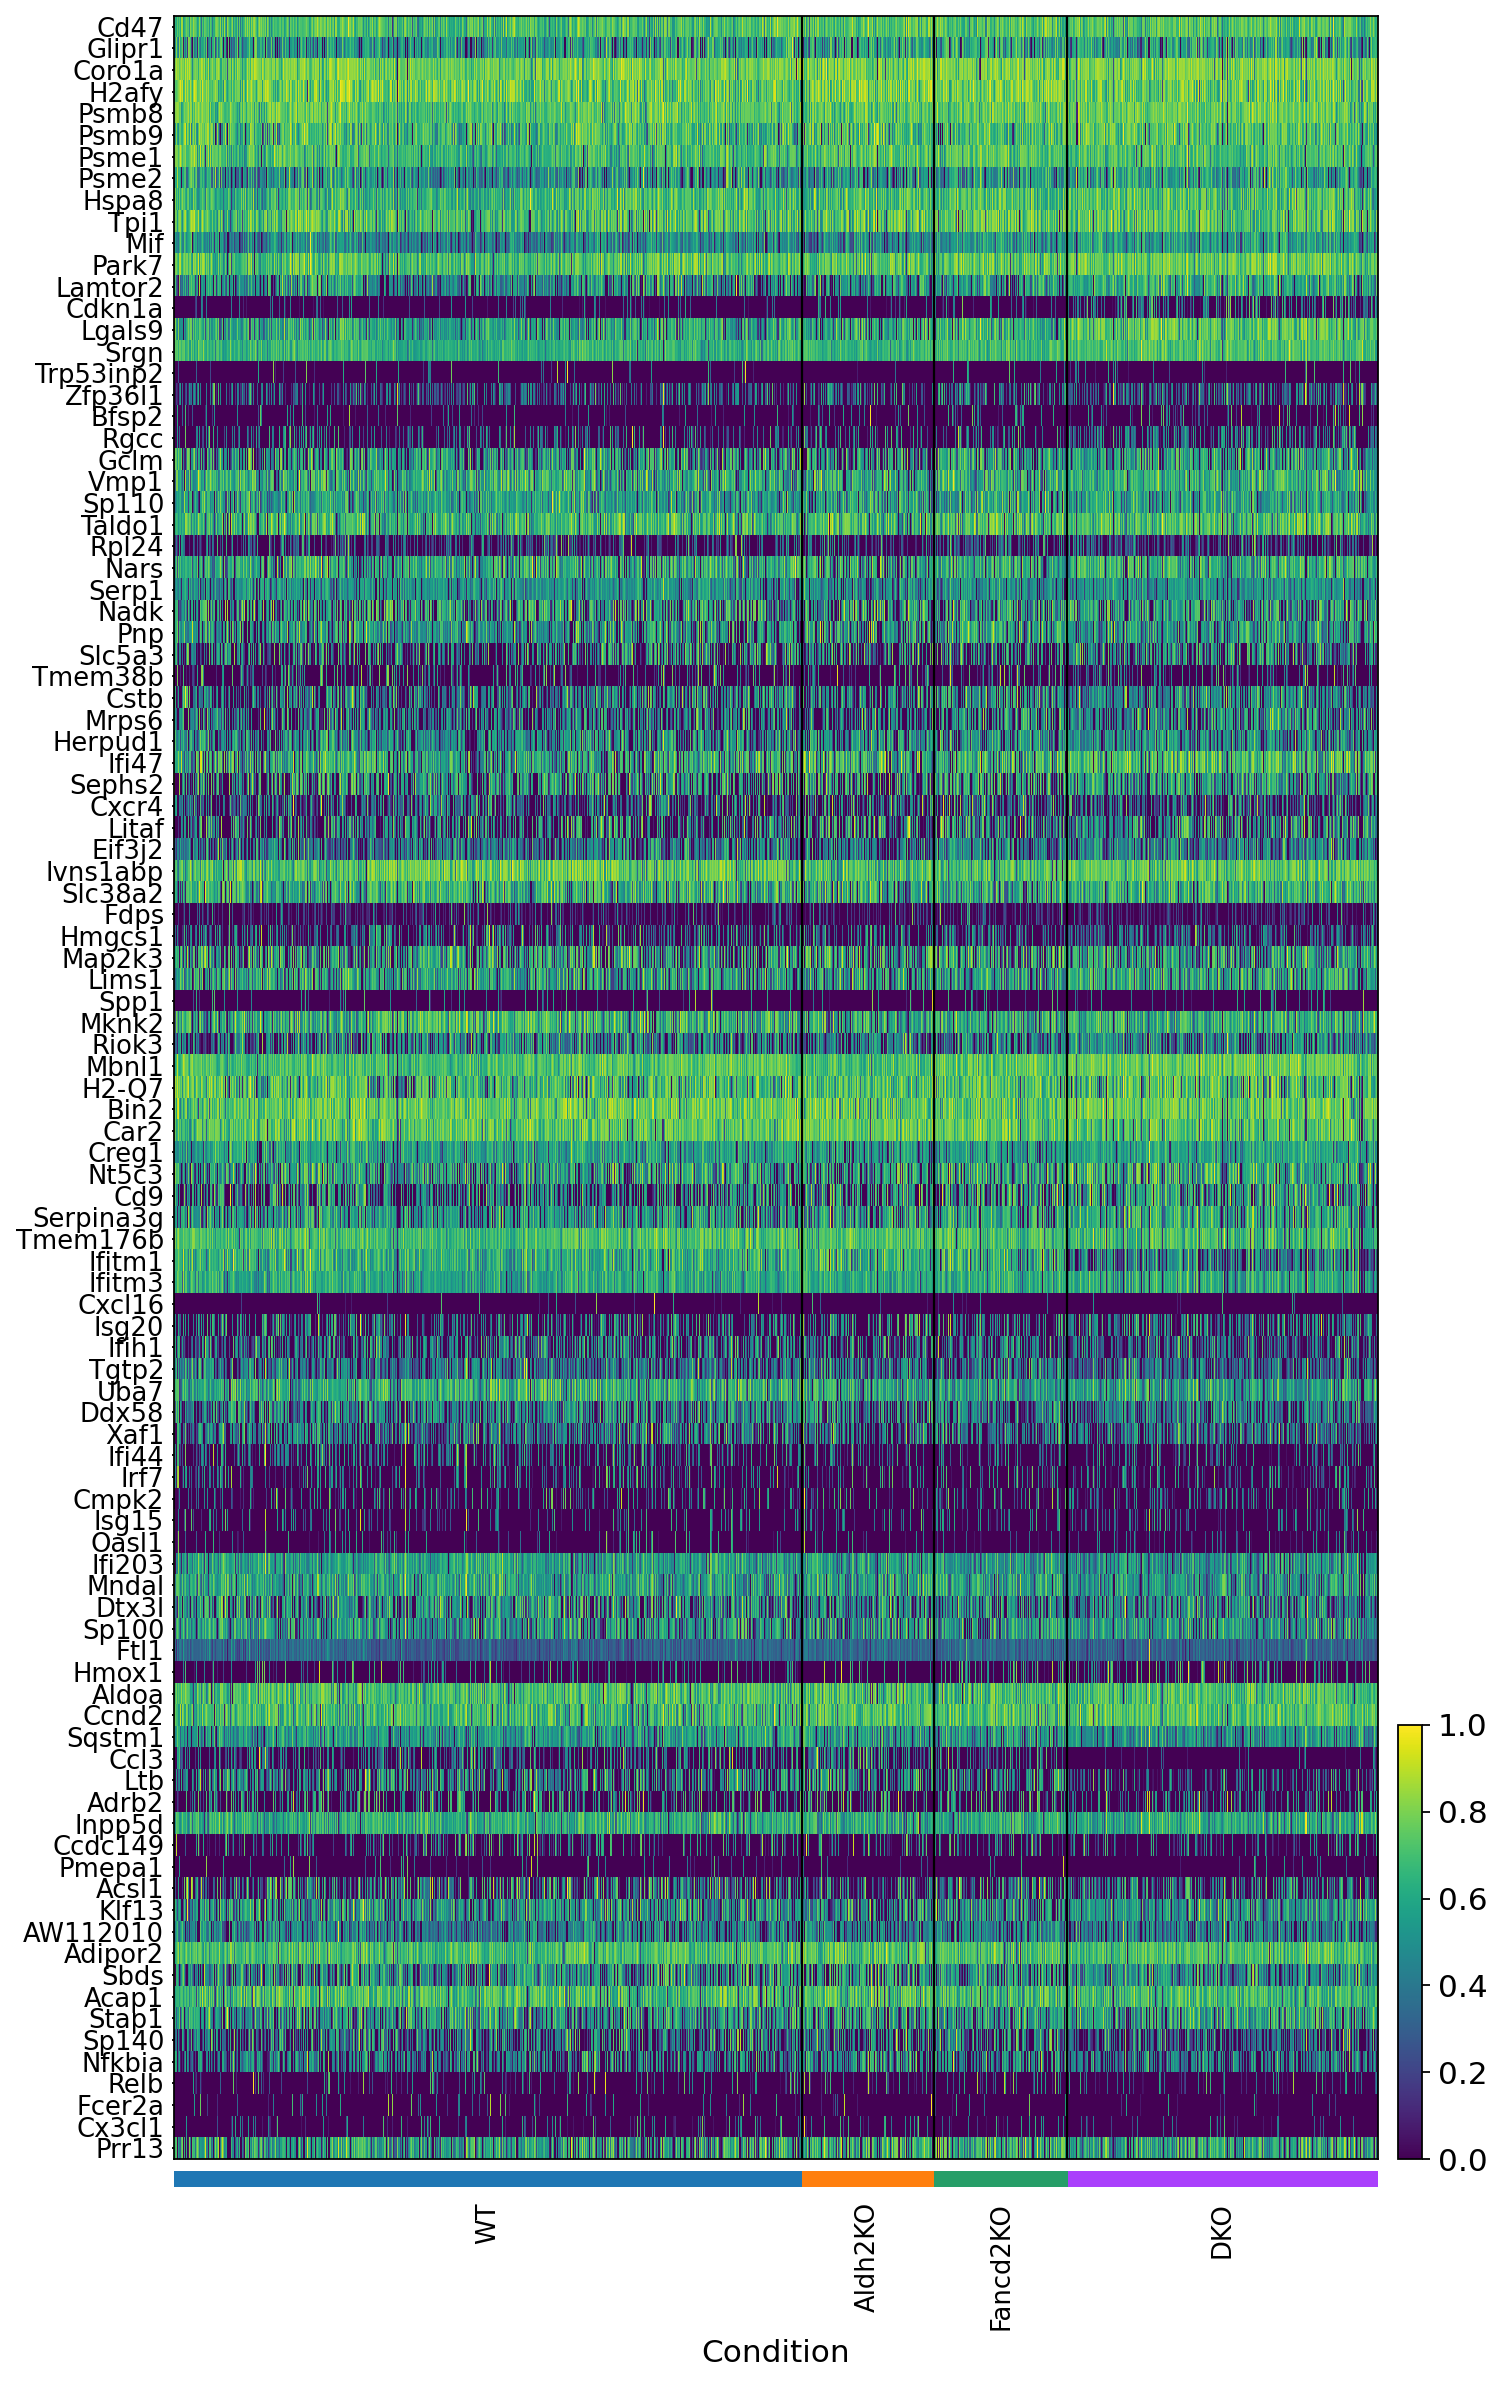

In [110]:
# FigureS2B
sc.pl.heatmap(adata, var_names=Gordered, groupby='Condition',swap_axes=True, show_gene_labels=True, standard_scale='var', save='Supp_Fig2a.pdf')